# Do Interictal DischargesAffect Functional Connectivity

author: Jeni Stiso (jeni.stiso@gmail.com)

words

In [150]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from statsmodels.stats.anova import AnovaRM
import palettable

%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster')
sns.set_style("whitegrid")

In [151]:
# directories - point this at you RAM data
RAM_dir = '/Volumes/bassett-data/Jeni/RAM/'
parcel_dir = '/Users/stiso/Documents/parcellations/'
win = 1
detector = '' # '_delphos' or ''

# load data
net_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/network_stats{detector}.csv', index_col=0)
node_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/node_stats{detector}.csv', index_col=0)

# drop duplicates
net_data.drop_duplicates(inplace=True)
node_data.drop_duplicates(inplace=True)

Check the data

In [152]:
net_data.head(10)

band_measure  n_tp  str_beta_bin  str_beta_num  str_soz_beta_bin  \
1         alpha_aec   107      0.854233     -0.308418          1.059740   
2   alpha_aec_ortho   107      0.740682     -0.253151          1.870519   
3         alpha_coh   107      0.590071     -0.136139          1.332877   
4         alpha_plv   107      1.382341     -0.571861          0.567091   
5          beta_aec   107     -0.241167     -0.055265         -0.172447   
6    beta_aec_ortho   107     -0.515795      0.135530          0.741471   
7          beta_coh   107     -1.400779      0.500620         -0.432153   
8          beta_plv   107     -0.163943     -0.016503          0.033498   
9      broadband_ar   107     -0.158835      0.027583          1.517864   
10  broadband_xcorr   107     -0.136929      0.094571         -0.258950   

    str_soz_beta_num  str_not_soz_beta_num  str_spike_beta_num  \
1          -0.420497             -0.270865           -0.142973   
2          -0.708609             -0.065400           -0.561334   
3          -0.490406             -0.045080            0.038881   
4          -0.355160             -0.562533           -0.177097   
5          -0.067385             -0.053229            0.043149   
6          -0.388206              0.259685           -0.101127   
7           0.107748              0.564379            1.149075   
8          -0.009530             -0.018310            0.190108   
9          -0.327882              0.112392            0.472010   
10          0.030778              0.082507            0.185026   

    str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
1               0.792757            0.498661                0.891197   
2               0.308119            1.454746                0.603182   
3               0.405967            0.215112                0.562521   
4               1.409217            0.125400                1.567178   
5              -0.215706           -0.657497               -0.123200   
6              -0.744336           -0.226195               -0.547767   
7              -1.537868           -3.177229               -1.007633   
8              -0.211830           -0.733566                0.137042   
9              -0.519845           -0.721341                0.161784   
10             -0.043459           -0.364730               -0.157725   

   fc_measure  str_not_spike_beta_num       band    subj hand   age gender  \
1         aec               -0.329908      alpha  R1170J    R  20.0      M   
2   aec_ortho               -0.168891      alpha  R1170J    R  20.0      M   
3         coh               -0.156657      alpha  R1170J    R  20.0      M   
4         plv               -0.599338      alpha  R1170J    R  20.0      M   
5         aec               -0.079059       beta  R1170J    R  20.0      M   
6   aec_ortho                0.179215       beta  R1170J    R  20.0      M   
7         coh                0.349140       beta  R1170J    R  20.0      M   
8         plv               -0.094981       beta  R1170J    R  20.0      M   
9          ar               -0.150413  broadband  R1170J    R  20.0      M   
10      xcorr                0.092500  broadband  R1170J    R  20.0      M   

    race  
1    2.0  
2    2.0  
3    2.0  
4    2.0  
5    2.0  
6    2.0  
7    2.0  
8    2.0  
9    2.0  
10   2.0

In [153]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4011 entries, 1 to 4011
Data columns (total 19 columns):
band_measure              4011 non-null object
n_tp                      4011 non-null int64
str_beta_bin              3948 non-null float64
str_beta_num              3948 non-null float64
str_soz_beta_bin          2856 non-null float64
str_soz_beta_num          2856 non-null float64
str_not_soz_beta_num      2844 non-null float64
str_spike_beta_num        2667 non-null float64
str_not_soz_beta_bin      2844 non-null float64
str_spike_beta_bin        2667 non-null float64
str_not_spike_beta_bin    2655 non-null float64
fc_measure                4011 non-null object
str_not_spike_beta_num    2655 non-null float64
band                      4011 non-null object
subj                      4011 non-null object
hand                      3948 non-null object
age                       3990 non-null float64
gender                    4011 non-null object
race                      3864 non-nu

In [154]:
net_data.describe()

n_tp  str_beta_bin  str_beta_num  str_soz_beta_bin  \
count  4011.000000   3948.000000   3948.000000       2856.000000   
mean   1059.131638     -0.238411      0.096677         -0.210654   
std    1222.874004      1.344664      0.422224          1.224989   
min      15.000000    -15.194886     -7.030166        -13.589867   
25%     234.000000     -0.592298     -0.059609         -0.559704   
50%     632.000000     -0.171345      0.053368         -0.145697   
75%    1224.000000      0.106776      0.240237          0.105454   
max    6184.000000     22.368412      4.797653         13.862246   

       str_soz_beta_num  str_not_soz_beta_num  str_spike_beta_num  \
count       2856.000000           2844.000000         2667.000000   
mean           0.097210              0.081167            0.107818   
std            0.383394              0.385949            0.396914   
min           -3.934828             -4.056621           -5.139745   
25%           -0.042328             -0.068075           -0.045072   
50%            0.052123              0.041100            0.062396   
75%            0.241567              0.227584            0.265015   
max            3.882369              3.272137            3.336776   

       str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
count           2844.000000         2667.000000             2655.000000   
mean              -0.197944           -0.231651               -0.183287   
std                1.255711            1.333911                1.335945   
min              -11.341547          -12.520063              -14.427106   
25%               -0.541606           -0.615501               -0.546791   
50%               -0.151663           -0.169247               -0.130859   
75%                0.113121            0.103886                0.157358   
max               14.845690           18.050007               14.723349   

       str_not_spike_beta_num          age         race  
count             2655.000000  3990.000000  3864.000000  
mean                 0.074211    35.863158     2.940217  
std                  0.408053    11.722445     1.225663  
min                 -3.996544    16.000000     1.000000  
25%                 -0.070063    26.000000     2.000000  
50%                  0.034845    34.000000     4.000000  
75%                  0.218629    44.000000     4.000000  
max                  3.555290    66.000000     7.000000

In [155]:
node_data.tail(10)

elec     band_measure  n_tp  elec_spike  elec_in_soz  \
413355  RPT4  gamma_aec_ortho  5624    0.001956            1   
413356  RPT4        gamma_coh  5624    0.001956            1   
413357  RPT4        gamma_plv  5624    0.001956            1   
413358  RPT4           hg_aec  5624    0.001956            1   
413359  RPT4     hg_aec_ortho  5624    0.001956            1   
413360  RPT4           hg_coh  5624    0.001956            1   
413361  RPT4        theta_aec  5624    0.001956            1   
413362  RPT4  theta_aec_ortho  5624    0.001956            1   
413363  RPT4        theta_coh  5624    0.001956            1   
413364  RPT4        theta_plv  5624    0.001956            1   

        str_soz_beta_bin  str_not_soz_beta_bin  str_spike_beta_bin  \
413355         -0.040308                   NaN            0.057842   
413356         -0.040186                   NaN            0.174675   
413357         -0.015477                   NaN           -0.068799   
413358         -0.013289                   NaN            0.079209   
413359          0.159412                   NaN            0.344415   
413360         -0.025710                   NaN            0.128799   
413361         -0.093182                   NaN           -0.107448   
413362         -0.129682                   NaN            0.087743   
413363          0.085486                   NaN            0.007874   
413364         -0.158660                   NaN            0.023124   

        str_not_spike_beta_bin  str_beta_bin  ...        region        x  \
413355               -0.043318     -0.040308  ...   postcentral  44.7886   
413356               -0.087534     -0.040186  ...   postcentral  44.7886   
413357                0.022138     -0.015477  ...   postcentral  44.7886   
413358               -0.011227     -0.013289  ...   postcentral  44.7886   
413359                0.127619      0.159412  ...   postcentral  44.7886   
413360               -0.046387     -0.025710  ...   postcentral  44.7886   
413361               -0.080986     -0.093182  ...   postcentral  44.7886   
413362               -0.188608     -0.129682  ...   postcentral  44.7886   
413363                0.106541      0.085486  ...   postcentral  44.7886   
413364               -0.213816     -0.158660  ...   postcentral  44.7886   

              y          z  type    subj hand   age  gender  race  
413355 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
413356 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
413357 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
413358 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
413359 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
413360 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
413361 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
413362 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
413363 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
413364 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  

[10 rows x 27 columns]

In [156]:
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413322 entries, 1 to 413364
Data columns (total 27 columns):
elec                      413322 non-null object
band_measure              413322 non-null object
n_tp                      413322 non-null int64
elec_spike                413322 non-null float64
elec_in_soz               413322 non-null int64
str_soz_beta_bin          286503 non-null float64
str_not_soz_beta_bin      264486 non-null float64
str_spike_beta_bin        265293 non-null float64
str_not_spike_beta_bin    234088 non-null float64
str_beta_bin              402633 non-null float64
str_soz_beta_num          286503 non-null float64
str_not_soz_beta_num      264486 non-null float64
str_spike_beta_num        265293 non-null float64
str_beta_num              402633 non-null float64
str_not_spike_beta_num    234088 non-null float64
fc_measure                413322 non-null object
band                      413322 non-null object
region                    373821 non-null objec

In [157]:
node_data.describe()

n_tp     elec_spike    elec_in_soz  str_soz_beta_bin  \
count  413322.000000  413322.000000  413322.000000     286503.000000   
mean      982.051592       0.020886       0.056448         -0.091447   
std      1156.341156       0.046209       0.230784          1.283743   
min        11.000000       0.000000       0.000000        -34.728424   
25%       184.000000       0.000000       0.000000         -0.339166   
50%       571.000000       0.003509       0.000000         -0.039668   
75%      1172.000000       0.018692       0.000000          0.149903   
max      6184.000000       0.600000       1.000000         34.486550   

       str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
count         264486.000000       265293.000000           234088.000000   
mean              -0.119754           -0.104301               -0.120645   
std                1.280645            1.316651                1.287076   
min              -50.197959          -32.102864              -51.584789   
25%               -0.399076           -0.390663               -0.406965   
50%               -0.065658           -0.046560               -0.065010   
75%                0.133148            0.150407                0.147104   
max               27.666095           32.106575               28.388302   

        str_beta_bin  str_soz_beta_num  str_not_soz_beta_num  \
count  402633.000000     286503.000000         264486.000000   
mean       -0.147178          0.050093              0.066029   
std         1.410433          0.379051              0.391426   
min       -51.197817         -8.286508             -7.864474   
25%        -0.438221         -0.048348             -0.045264   
50%        -0.073171          0.018830              0.027894   
75%         0.142376          0.142038              0.171710   
max        34.486550          9.176234             14.394327   

       str_spike_beta_num   str_beta_num  str_not_spike_beta_num  \
count       265293.000000  402633.000000           234088.000000   
mean             0.058033       0.079441                0.065322   
std              0.397327       0.430860                0.397191   
min             -7.474270      -8.115780               -7.721516   
25%             -0.048781      -0.043108               -0.047623   
50%              0.022181       0.034837                0.027731   
75%              0.161537       0.190540                0.172039   
max              8.984809      14.644936               14.772548   

                   x              y              z            age  \
count  318045.000000  318045.000000  318045.000000  408891.000000   
mean       -6.627663      -7.265151       4.091575      35.972985   
std        46.244683      36.422703      45.593994      11.813946   
min      -165.993000    -143.909000    -402.070855      16.000000   
25%       -45.059700     -31.130200     -19.043106      26.000000   
50%       -15.540900      -8.306500       1.714493      34.000000   
75%        34.090700      15.793600      32.040331      45.000000   
max       173.816000     207.770000      93.980799      66.000000   

                race  
count  401016.000000  
mean        2.935170  
std         1.228114  
min         1.000000  
25%         2.000000  
50%         4.000000  
75%         4.000000  
max         7.000000

Basic EDA: check distribution of demographics, replace NaNs where appropriate, etc

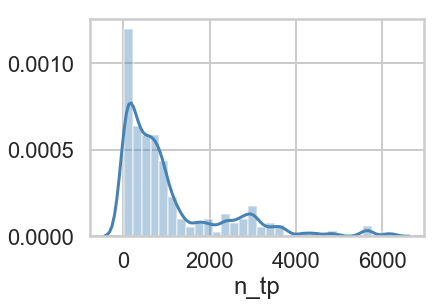

In [158]:
sns.distplot(net_data['n_tp'], bins=30, color='steelblue')

In [159]:
net_data.subj.nunique()

186

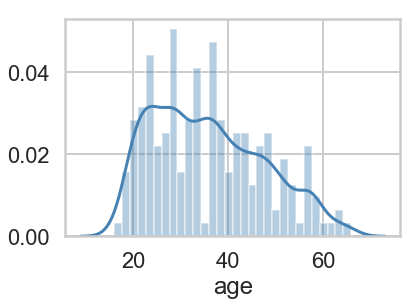

In [160]:
net_data['age'].replace(to_replace=0, value=None, inplace=True)
sns.distplot(net_data['age'].dropna(), bins=30, color='steelblue')
mean_age = net_data['age'].mean()

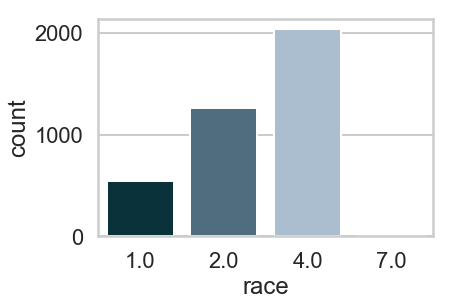

In [161]:
sns.countplot(data=net_data, x='race', )
mean_race = 4

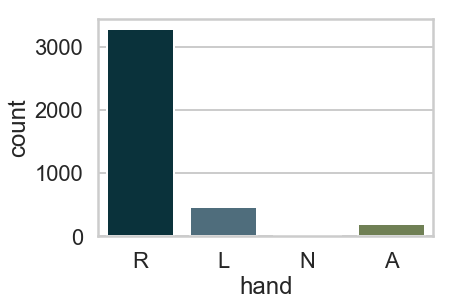

In [162]:
sns.countplot(data=net_data, x='hand', )
mean_hand = 'R'

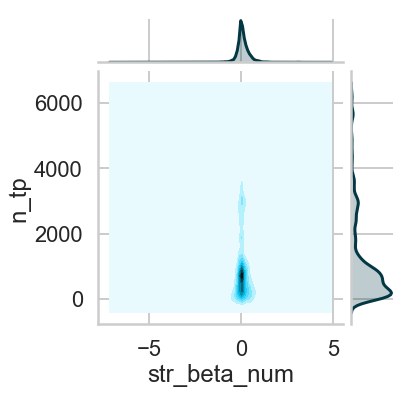

In [163]:
sns.jointplot(data=net_data, x='str_beta_num', y='n_tp', kind='kde' )

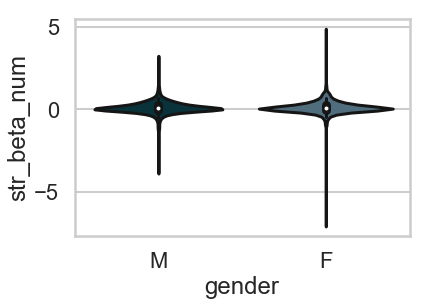

In [164]:
sns.violinplot(data=net_data, x='gender', y='str_beta_num', cut=True)

In [165]:
# add means for null values
net_data.loc[net_data['age'].isnull(), 'age'] = mean_age
net_data.loc[net_data['race'].isnull(), 'race'] = mean_race
net_data.loc[net_data['hand'].isnull(), 'hand'] = mean_hand

# same for node data
node_data.loc[node_data['age'].isnull(), 'age'] = mean_age
node_data.loc[node_data['race'].isnull(), 'race'] = mean_race
node_data.loc[node_data['hand'].isnull(), 'hand'] = mean_hand

In [166]:
# check for duplicates, these two numbers should match
print(net_data.dropna().subj.nunique())
print(net_data[net_data.band_measure == 'theta_plv'].dropna().subj.count())

115
115


In [167]:
node_data.dropna(axis=0).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150368 entries, 1 to 413353
Data columns (total 27 columns):
elec                      150368 non-null object
band_measure              150368 non-null object
n_tp                      150368 non-null int64
elec_spike                150368 non-null float64
elec_in_soz               150368 non-null int64
str_soz_beta_bin          150368 non-null float64
str_not_soz_beta_bin      150368 non-null float64
str_spike_beta_bin        150368 non-null float64
str_not_spike_beta_bin    150368 non-null float64
str_beta_bin              150368 non-null float64
str_soz_beta_num          150368 non-null float64
str_not_soz_beta_num      150368 non-null float64
str_spike_beta_num        150368 non-null float64
str_beta_num              150368 non-null float64
str_not_spike_beta_num    150368 non-null float64
fc_measure                150368 non-null object
band                      150368 non-null object
region                    150368 non-null objec

In [168]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_data_clean{detector}.csv')

## Effects on Network Measures

visualize how much spikes regularly change network strength.

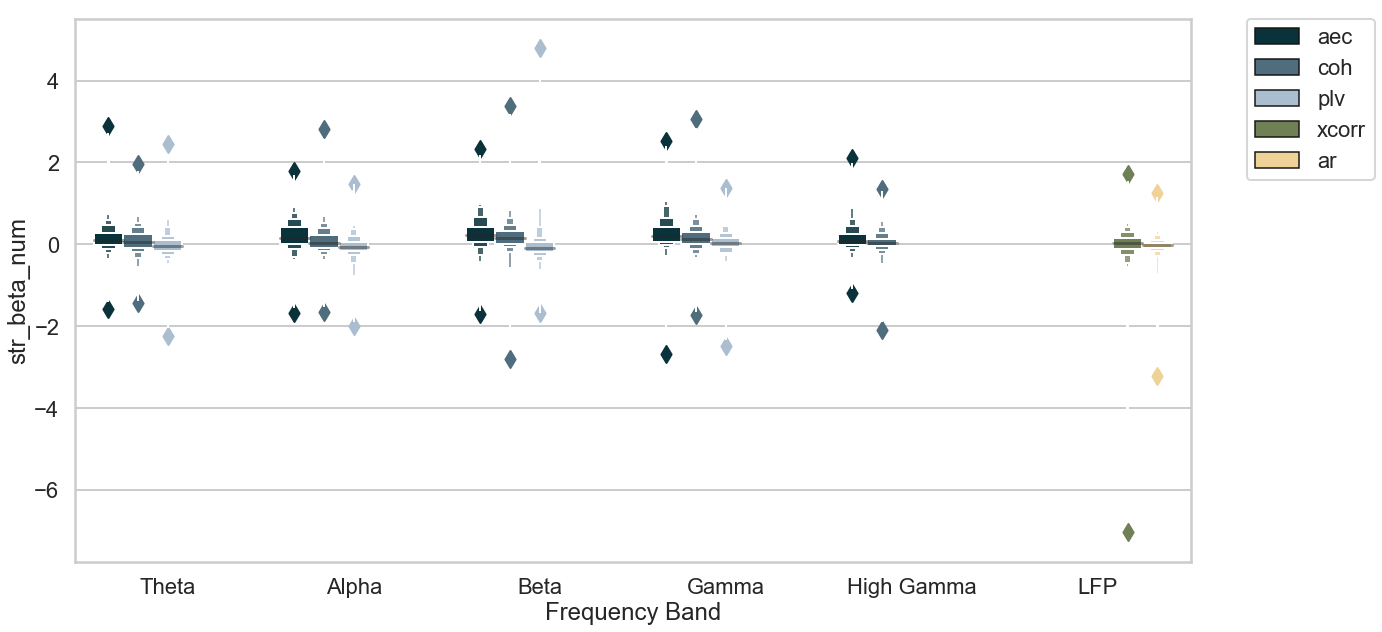

In [169]:


# rename stuff so it looks prettier - do the rest in illustrator
net_data.replace({'band':{'theta':'Theta', 'alpha':'Alpha', 'beta':'Beta', 'gamma':'Gamma', 
                              'hg':'High Gamma', 'broadband':'LFP'}}, inplace=True)
net_data.rename(columns={'band':'Frequency Band', 'fc_measure':'Measure'}, inplace=True)

# parameters
supp_flag = False # if true, includes orthogonal AEC
y_var = 'num'

if (not supp_flag):
    h_order = ['aec', 'coh', 'plv', 'xcorr', 'ar']
    supp_ext = ''
    # colors
    colors = ['#023743', '#476f84', '#A4BED5', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
else:
    h_order = ['aec_ortho', 'aec', 'coh', 'plv', 'xcorr', 'ar']
    supp_ext = '_supp'
    # color pallette
    colors = ['#453947', '#023743',  '#476F84', '#A4BED5', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
    
plt.figure(figsize=(20,10))
sns.boxenplot( data=net_data, x="Frequency Band", y='str_beta_' + y_var, hue='Measure', 
            order=['Theta','Alpha','Beta','Gamma','High Gamma','LFP'], hue_order=h_order)
#sns.stripplot( data=net_data, x="band", y='str_beta_bin',hue='fc_measure',color='black',jitter=True, dodge=True,
#            alpha=.2, zorder=1, size=6, order=['theta','alpha','beta','gamma','hg','broadband'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim(-2,2)
plt.savefig(f"../img/net_{y_var}_str{detector}{supp_ext}.eps")


Is it different within or outside of the SOZ?

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


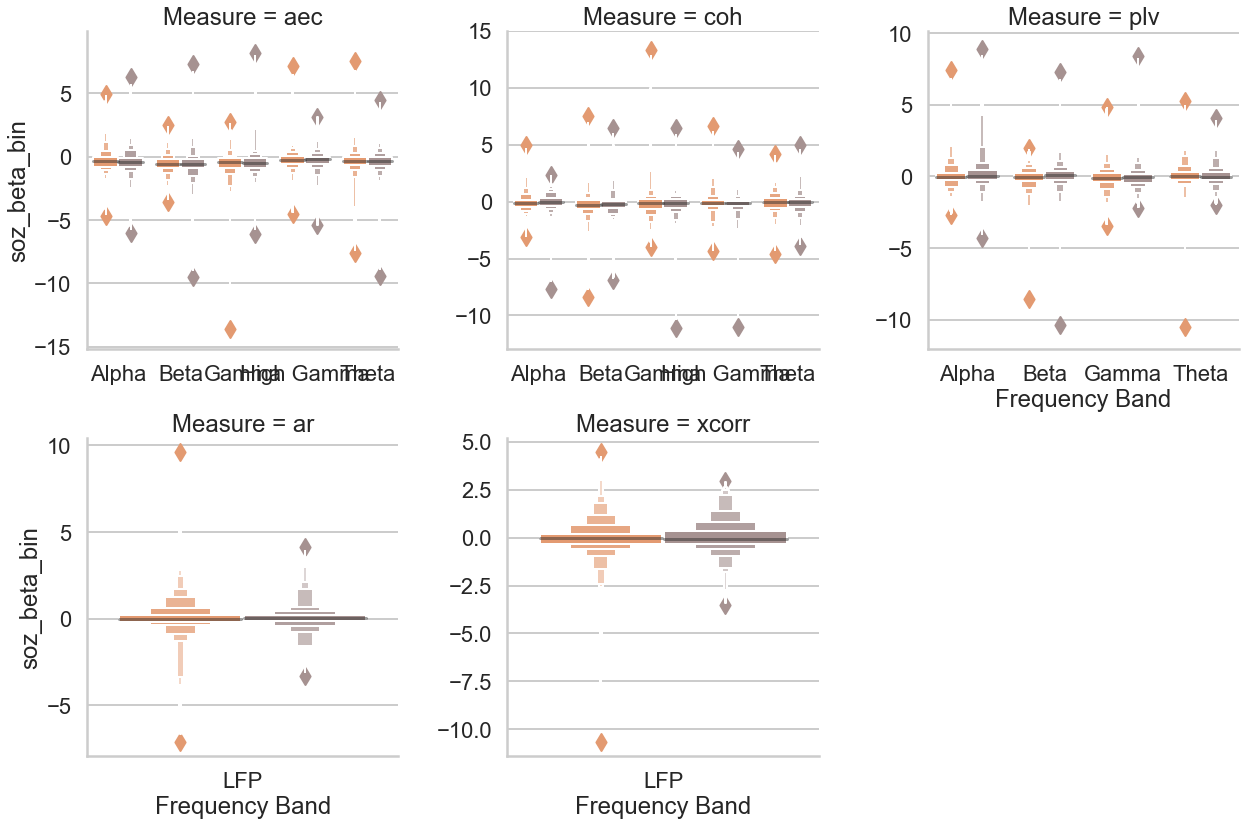

In [170]:
# reshape data
soz_net_data_bin = pd.melt(net_data, id_vars =['Frequency Band', 'Measure', 'subj', 'hand','race','gender','age'], 
                           value_vars =['str_soz_beta_bin','str_not_soz_beta_bin'],  
                           var_name ='SOZ', value_name ='soz_beta_bin')  
soz_net_data_bin = soz_net_data_bin[soz_net_data_bin['Measure'] != 'aec_ortho']

#color pallette
colors = ['#F6955E', '#A98F8E']
    
g = sns.FacetGrid(data=soz_net_data_bin, col='Measure' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, )
g.map(sns.boxenplot, 'Frequency Band', 'soz_beta_bin', 'SOZ', palette = sns.color_palette(colors), 
      hue_order=['str_soz_beta_bin','str_not_soz_beta_bin'])
#g.map(sns.stripplot, 'fc_measure', 'soz_beta_bin', 'SOZ',jitter=True, dodge=True,
#              alpha=.2, zorder=1, size=6, hue_order=['str_soz_beta_bin','str_not_soz_beta_bin'])
# g.axes[0].set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)
# g.axes[1].set_xticklabels(g.axes[1].xaxis.get_majorticklabels(),rotation=30)
# g.axes[2].set_xticklabels(g.axes[2].xaxis.get_majorticklabels(),rotation=30)
#g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    
g.savefig(f"../img/net_soz_bin{detector}.eps")

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


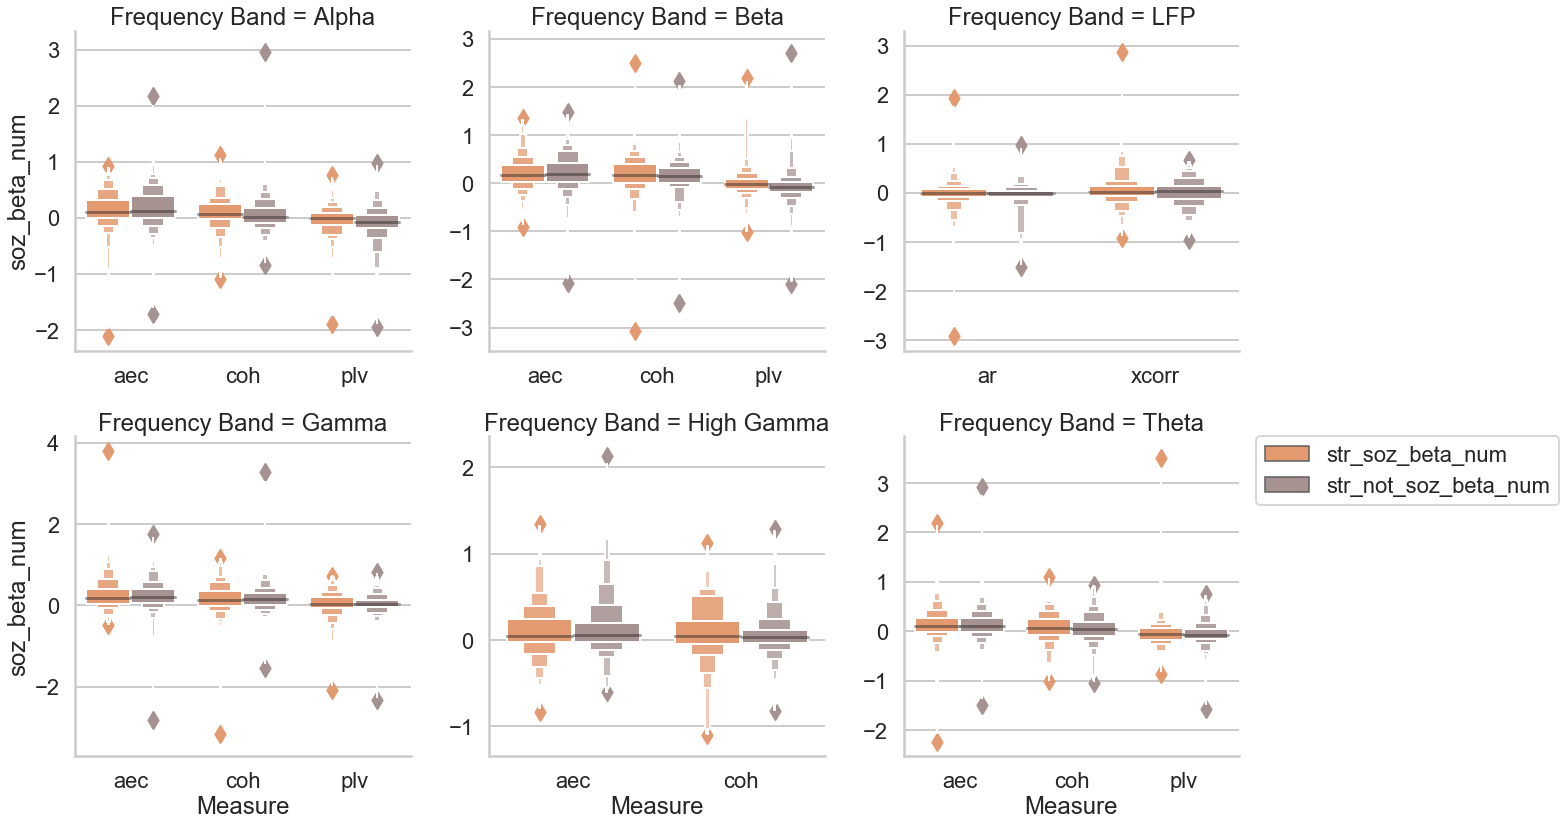

In [171]:
# reshape data
soz_net_data_num = pd.melt(net_data, id_vars =['Frequency Band', 'Measure', 'subj', 'hand','race','gender','age'], value_vars =['str_soz_beta_num','str_not_soz_beta_num'],  var_name ='SOZ', value_name ='soz_beta_num')  
soz_net_data_num = soz_net_data_num[soz_net_data_num['Measure'] != 'aec_ortho']

    
g = sns.FacetGrid(data=soz_net_data_num, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6)
g.map(sns.boxenplot, 'Measure', 'soz_beta_num', 'SOZ', palette = sns.color_palette(colors), hue_order=['str_soz_beta_num','str_not_soz_beta_num'])
#g.map(sns.stripplot, 'fc_measure', 'soz_beta_num', 'SOZ',jitter=True, dodge=True,
#              alpha=.2, zorder=1, size=6, hue_order=['str_soz_beta_num','str_not_soz_beta_num'])
# g.axes[0].set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)
# g.axes[1].set_xticklabels(g.axes[1].xaxis.get_majorticklabels(),rotation=30)
# g.axes[2].set_xticklabels(g.axes[2].xaxis.get_majorticklabels(),rotation=30)
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    
g.savefig(f"../img/net_soz_num{detector}.eps")

In [172]:
# save
# reformat before merge
soz_net_data_bin['SOZ'].replace('str_soz_beta_bin','within', inplace=True)
soz_net_data_bin['SOZ'].replace('str_not_soz_beta_bin','outside', inplace=True)
soz_net_data_num['SOZ'].replace('str_soz_beta_num','within', inplace=True)
soz_net_data_num['SOZ'].replace('str_not_soz_beta_num','outside', inplace=True)
soz_net_data = pd.merge(soz_net_data_bin, soz_net_data_num, on=['Frequency Band', 'Measure', 'subj', 'SOZ', 'hand','race','gender','age'])
soz_net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_soz_data_clean{detector}.csv')

Repeat for spikes

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


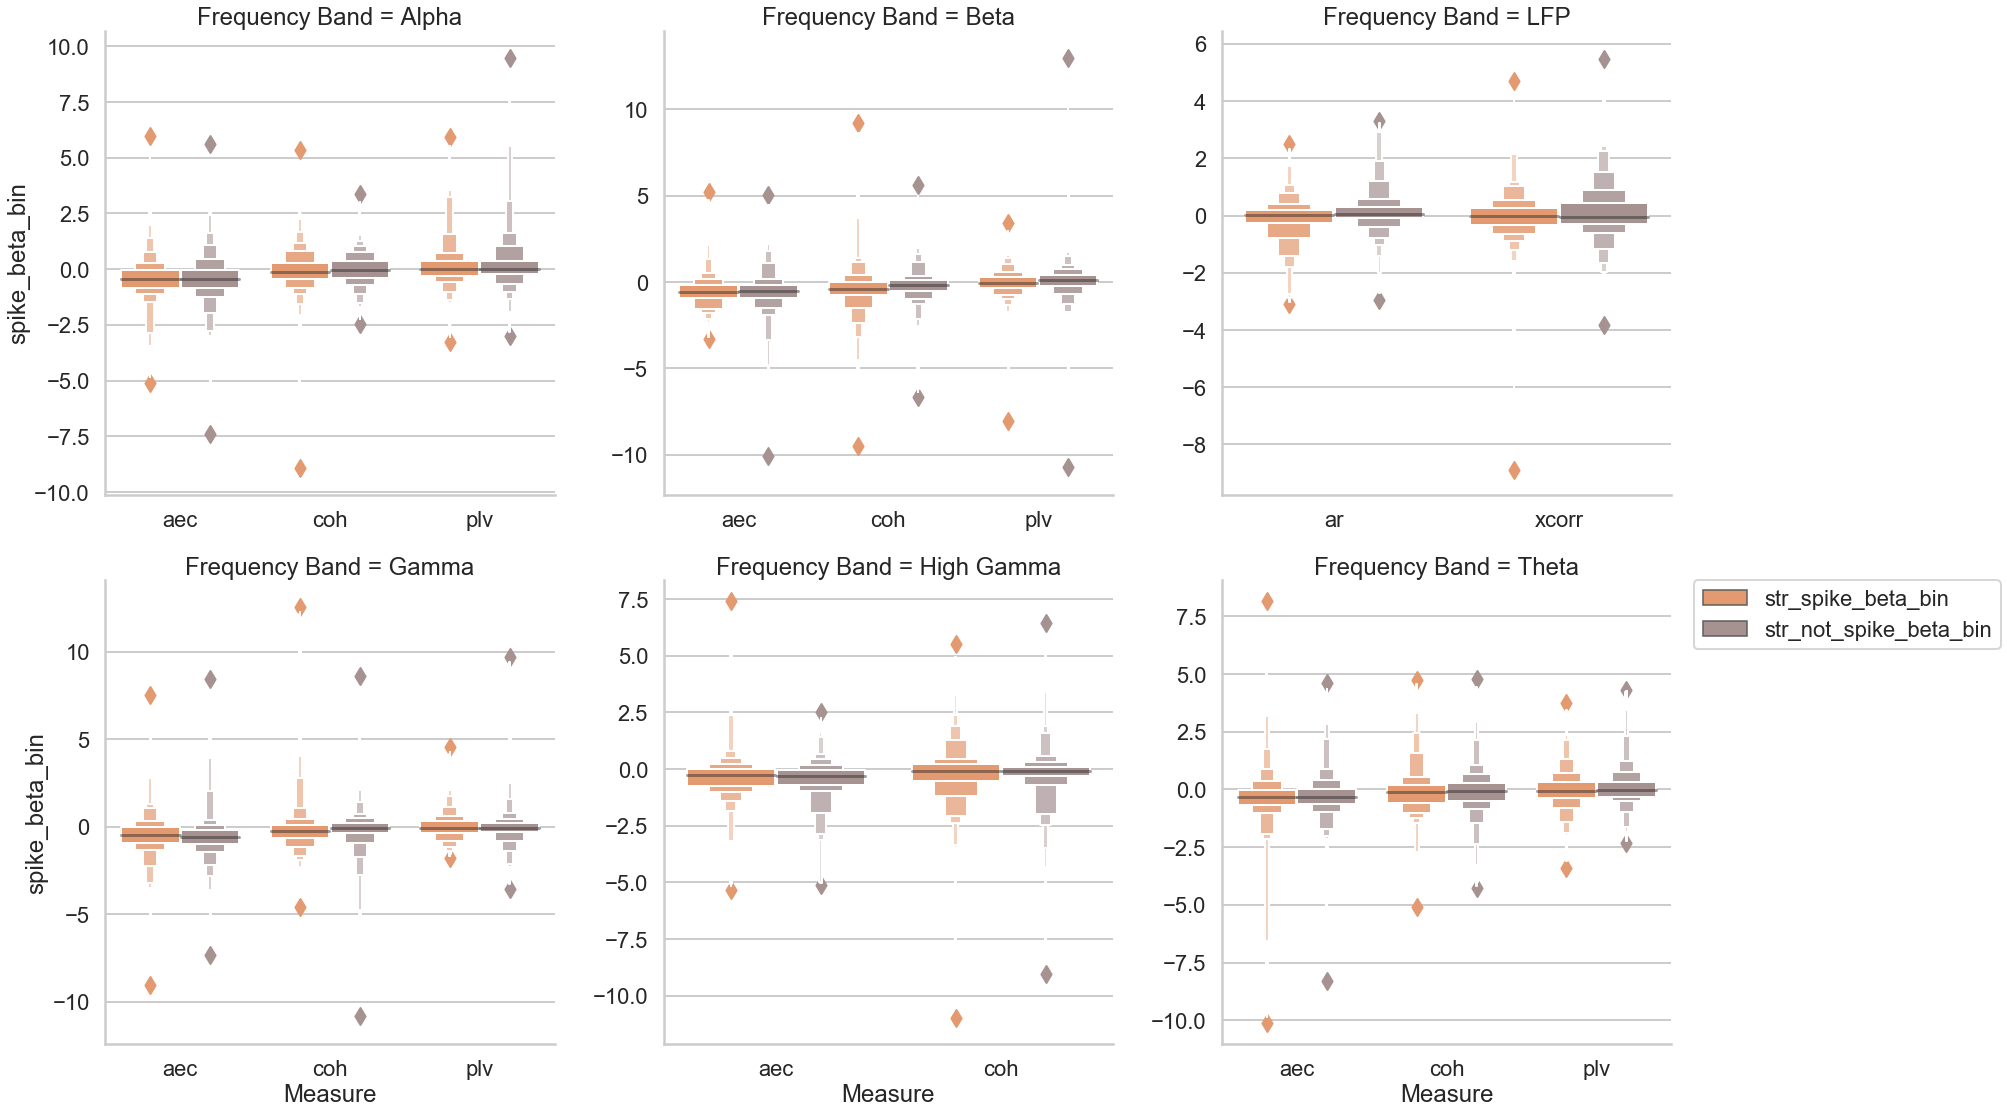

In [173]:
# reshape data
spike_net_data_bin = pd.melt(net_data, id_vars =['Frequency Band', 'Measure', 'subj', 'hand','race','gender','age'], 
                             value_vars =['str_spike_beta_bin','str_not_spike_beta_bin'],  
                             var_name ='spike', value_name ='spike_beta_bin')  
spike_net_data_bin = spike_net_data_bin[spike_net_data_bin['Measure'] != 'aec_ortho']

    
g = sns.FacetGrid(data=spike_net_data_bin, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'spike_beta_bin', 'spike', palette = sns.color_palette(colors), hue_order=['str_spike_beta_bin','str_not_spike_beta_bin'])
#g.map(sns.stripplot, 'fc_measure', 'spike_beta_bin', 'spike',jitter=True, dodge=True,
#              alpha=.2, zorder=1, size=6, hue_order=['str_spike_beta_bin','str_not_spike_beta_bin'])
# g.axes[0].set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)
# g.axes[1].set_xticklabels(g.axes[1].xaxis.get_majorticklabels(),rotation=30)
# g.axes[2].set_xticklabels(g.axes[2].xaxis.get_majorticklabels(),rotation=30)
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
#    plt.setp(ax.lines, color=".9")
    
g.savefig(f"../img/net_spike_bin{detector}.eps")

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


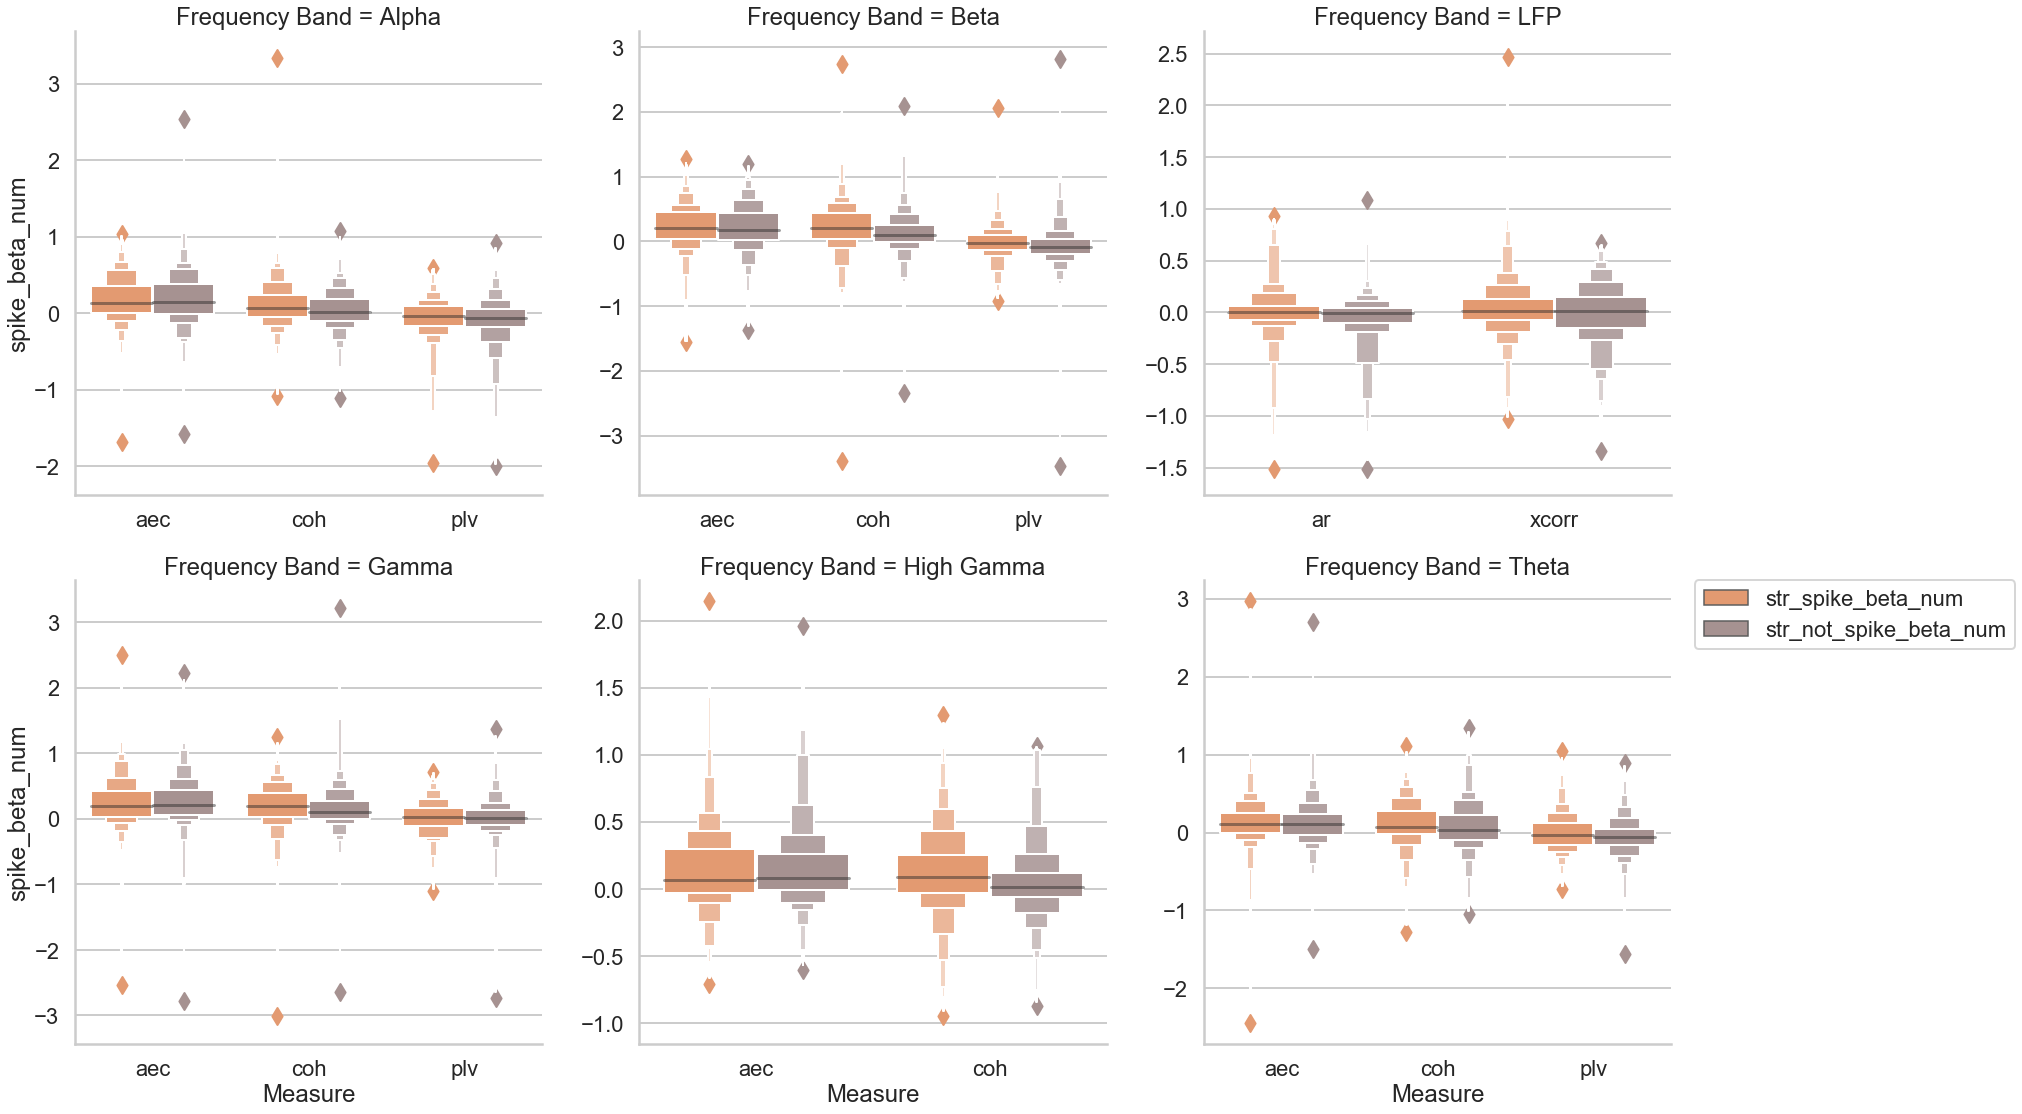

In [174]:
# reshape data
spike_net_data_num = pd.melt(net_data, id_vars =['Frequency Band', 'Measure', 'subj', 'hand','race','gender','age'], 
                             value_vars =['str_spike_beta_num','str_not_spike_beta_num'],  
                             var_name ='spike', value_name ='spike_beta_num')  
spike_net_data_num = spike_net_data_num[spike_net_data_num['Measure'] != 'aec_ortho']
    
g = sns.FacetGrid(data=spike_net_data_num, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'spike_beta_num', 'spike', palette = sns.color_palette(colors), hue_order=['str_spike_beta_num','str_not_spike_beta_num'])
#g.map(sns.stripplot, 'fc_measure', 'spike_beta_num', 'spike',jitter=True, dodge=True,
#              alpha=.2, zorder=1, size=6, hue_order=['str_spike_beta_num','str_not_spike_beta_num'])
# g.axes[0].set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)
# g.axes[1].set_xticklabels(g.axes[1].xaxis.get_majorticklabels(),rotation=30)
# g.axes[2].set_xticklabels(g.axes[2].xaxis.get_majorticklabels(),rotation=30)
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    
g.savefig(f"../img/net_spike_num{detector}.eps")

In [175]:
# save
# reformat before merge
spike_net_data_bin['spike'].replace('str_spike_beta_bin','within', inplace=True)
spike_net_data_bin['spike'].replace('str_not_spike_beta_bin','outside', inplace=True)
spike_net_data_num['spike'].replace('str_spike_beta_num','within', inplace=True)
spike_net_data_num['spike'].replace('str_not_spike_beta_num','outside', inplace=True)
spike_net_data = pd.merge(spike_net_data_bin, spike_net_data_num, on=['Frequency Band', 'Measure', 'subj', 'spike', 'hand','race','gender','age'])
spike_net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_spike_data_clean{detector}.csv')

## Effects on Node Measures

relationship between the number of spikes seen in that node, and the beta value

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


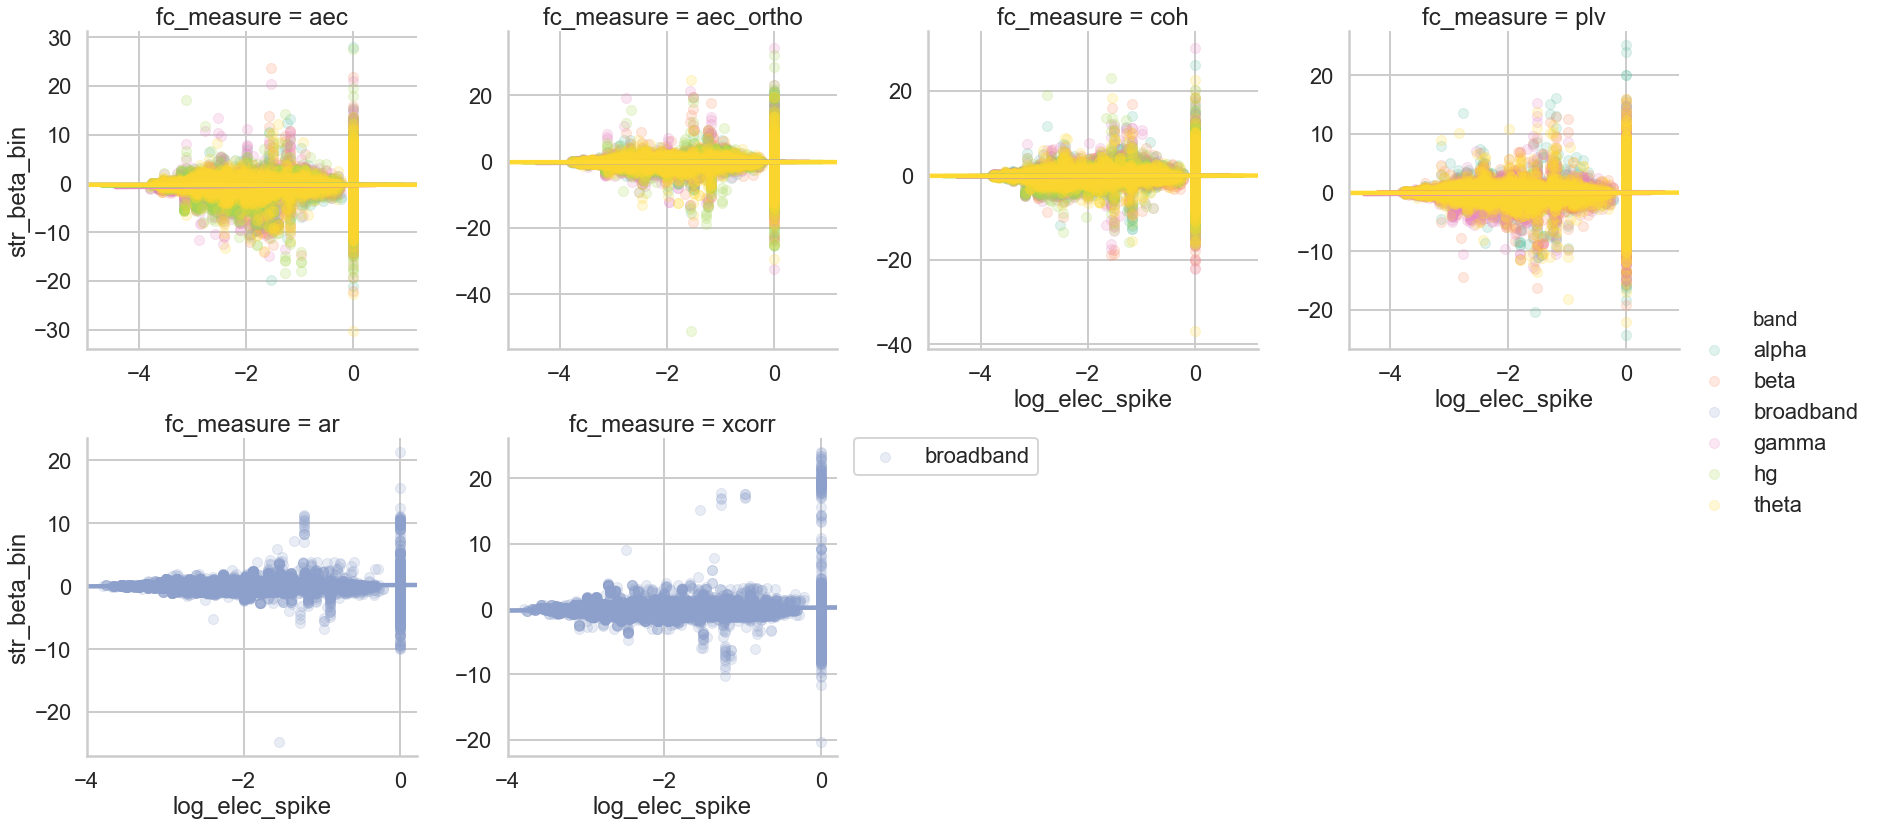

In [11]:
# add log transform
log_spike = np.zeros(np.shape(node_data['elec_spike']))
log_spike[[node_data['elec_spike'] != 0]] = np.log10(node_data['elec_spike'][node_data['elec_spike'] != 0])
node_data['log_elec_spike'] = log_spike

#color pallette
colors = ['#5b6c88', '#f0eee2']
custom_palette = sns.set_palette('Set2')

#plt.figure(figsize=(40,20))
sns.lmplot(data=node_data, x='log_elec_spike', y='str_beta_bin', hue='band', col="fc_measure", 
           col_wrap=4, height=6, sharex=False, sharey=False, scatter_kws={'s':100, 'alpha':.2})

plt.legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    

Total strength by type

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


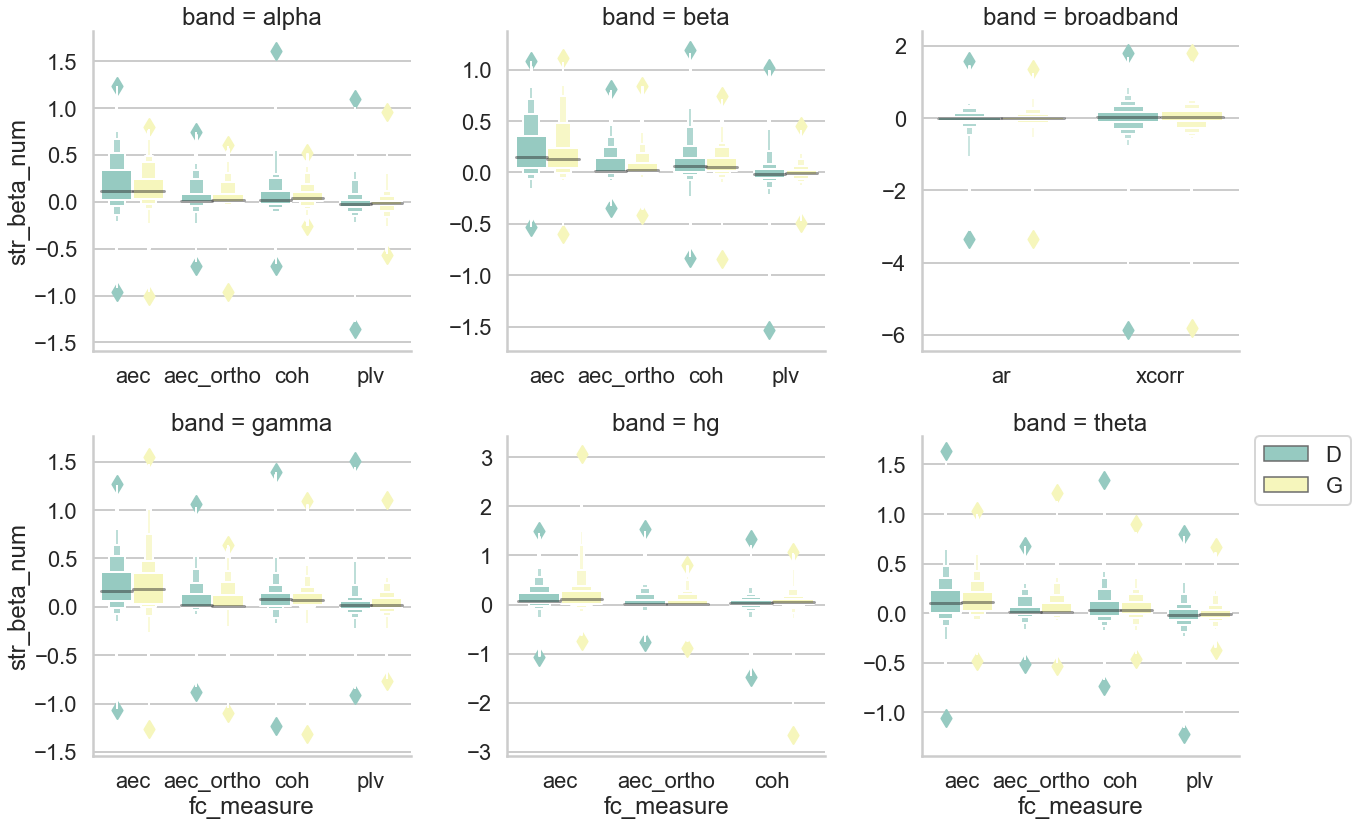

In [182]:
# strip is functionally the same as depth
node_data.loc[node_data.type == 'S','type'] = 'G'
type_avg = node_data.groupby(['subj', 'band', 'fc_measure', 'type']).median().reset_index()

# grand teton natl park color pallette
colors = ['#a8d0cf', '#babbb1']
custom_palette = sns.set_palette(sns.color_palette(colors))
    
g = sns.FacetGrid(data=type_avg, col='band', col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, size=6)
g.map(sns.boxenplot, 'fc_measure', 'str_beta_num', 'type', palette = 'Set3', hue_order = ['D','G'])

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
type_avg.to_csv(f'{RAM_dir}group_analysis/win_{win}/type_stats{detector}.csv')

In [183]:
# load system data
sys = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/contact_sys{detector}.csv', index_col=0)


In [184]:
# check number of contacts
sys['sys'].value_counts()

Vis            97147
Default         4608
Limbic          2398
SalVentAttn     1960
SomMot          1601
Cont            1396
DorsAttn        1341
Name: sys, dtype: int64

In [185]:
# merge
node_data = pd.merge(node_data, sys, on=['subj', 'elec', 'region', 'x' ,'y', 'z', 'race', 
                                         'hand', 'gender', 'type', 'age'])
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2136414 entries, 0 to 2136413
Data columns (total 30 columns):
elec                      object
band_measure              object
n_tp                      int64
elec_spike                float64
elec_in_soz               int64
str_soz_beta_bin          float64
str_not_soz_beta_bin      float64
str_spike_beta_bin        float64
str_not_spike_beta_bin    float64
str_beta_bin              float64
str_soz_beta_num          float64
str_not_soz_beta_num      float64
str_spike_beta_num        float64
str_beta_num              float64
str_not_spike_beta_num    float64
fc_measure                object
band                      object
region                    object
x                         float64
y                         float64
z                         float64
type                      object
subj                      object
hand                      object
age                       float64
gender                    object
race            

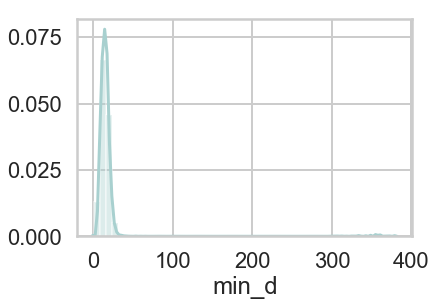

In [186]:
# how well are the MNI coordinates doing? Are centroids usually close?
sns.distplot(node_data['min_d'].dropna())

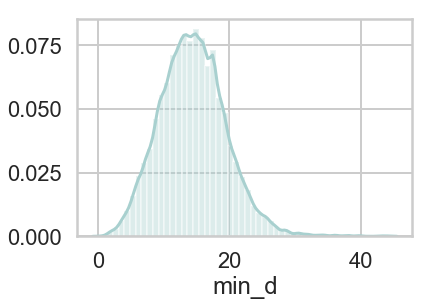

In [187]:
# get reid of contacts that clearly had poor match - greater than 2 std
node_data.loc[node_data['min_d'] > node_data['min_d'].mean() + node_data['min_d'].std(),['sys', 'parc', 'min_d']] = np.nan
sns.distplot(node_data['min_d'].dropna())

In [188]:
# get region -> system mapping to see if the MNI labels are any good
reg_sys_map = node_data.groupby(['subj', 'elec'])[['region','sys']]
reg_sys_map = reg_sys_map.head().dropna()
reg_sys_map.insert(2, 'cmb', reg_sys_map.apply(lambda x: x['region'] + x['sys'], axis=1))
reg_sys_map.to_csv(f'{RAM_dir}group_analysis/win_{win}/reg_sys_map{detector}.csv')
reg_sys_map.head()


region      sys                      cmb
0  inferiorparietal  Default  inferiorparietalDefault
1  inferiorparietal  Default  inferiorparietalDefault
2  inferiorparietal  Default  inferiorparietalDefault
3  inferiorparietal  Default  inferiorparietalDefault
4  inferiorparietal  Default  inferiorparietalDefault

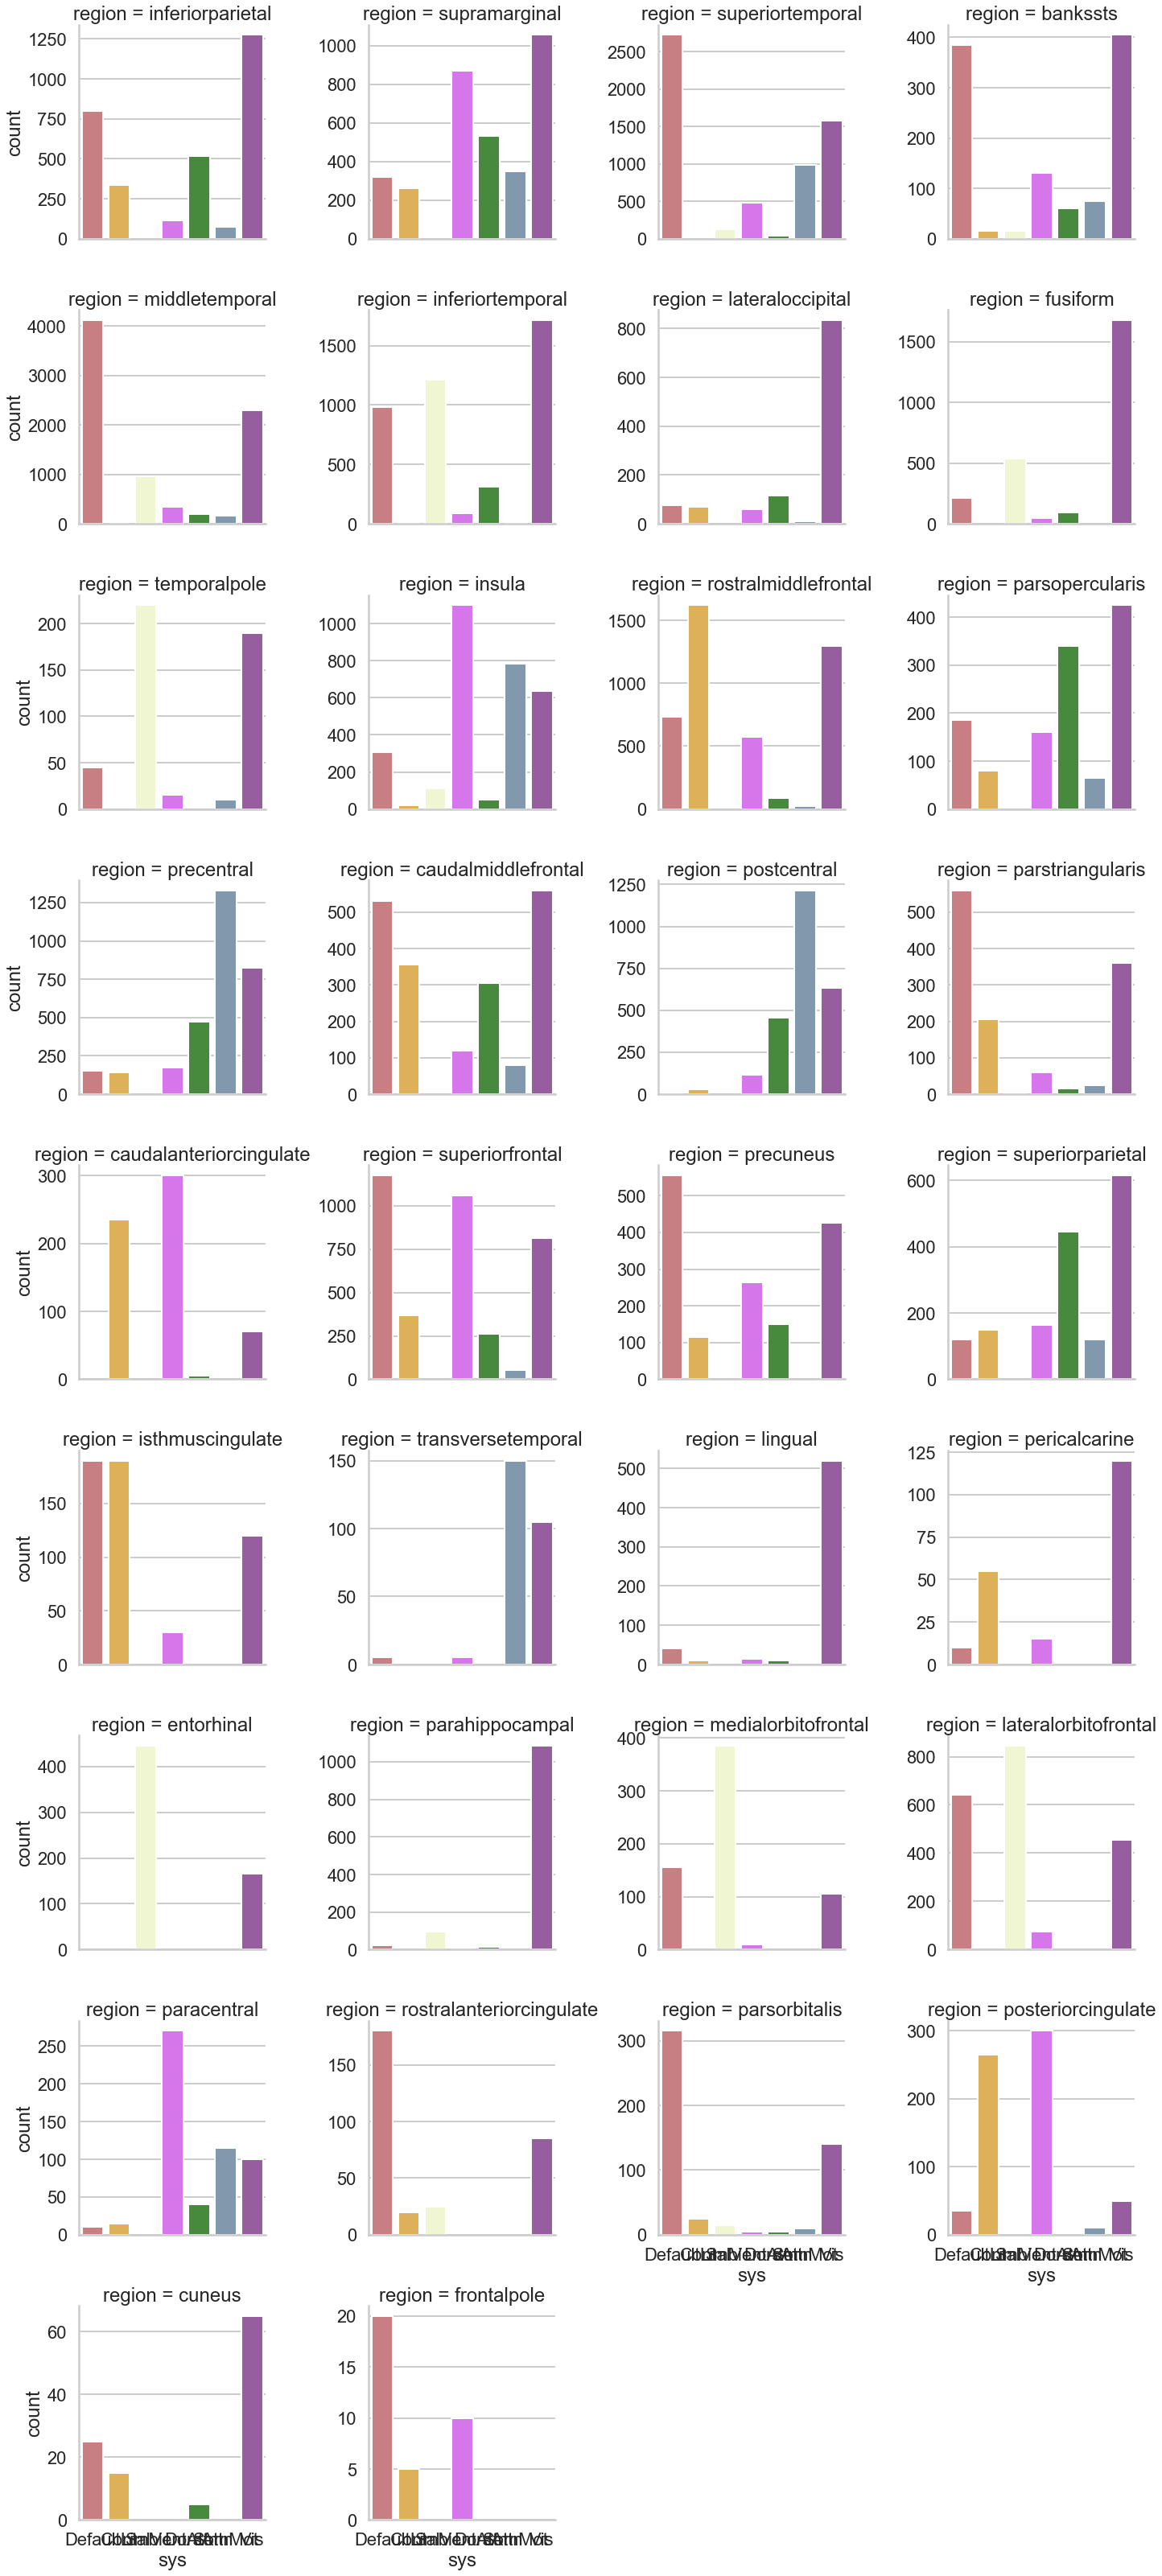

In [189]:
sys_colors = ['#d37379', '#f3b743', '#f5fccc', '#e164fe', '#3e9730', '#7b98b3', '#9f53aa']
sys_pal = sns.color_palette(sys_colors)
sns.catplot(data=reg_sys_map, x='sys', col='region', kind='count', col_wrap=4, sharey=False,
           order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'],
           palette=sys_pal)


In [191]:
# z-score within subject
#node_data.drop(['scale_num', 'scale_bin'], axis=1, inplace=True) # comment this out if defining scaled vars for the first time
node_data.insert(5, 'scale_num', node_data.groupby(['subj', 'band_measure'])['str_beta_num'].transform(
    lambda x: sp.stats.zscore(x)))
node_data.insert(5, 'scale_bin', node_data.groupby(['subj', 'band_measure'])['str_beta_bin'].transform(
    lambda x: sp.stats.zscore(x)))
# average over systems, so every subj has 1 pt per sys (if they had coverage there)
sys_avg = node_data.groupby(['subj', 'band', 'fc_measure', 'sys'])['scale_num', 'scale_bin'].median().reset_index()
sys_avg.head()
sys_avg.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_stats.csv')

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


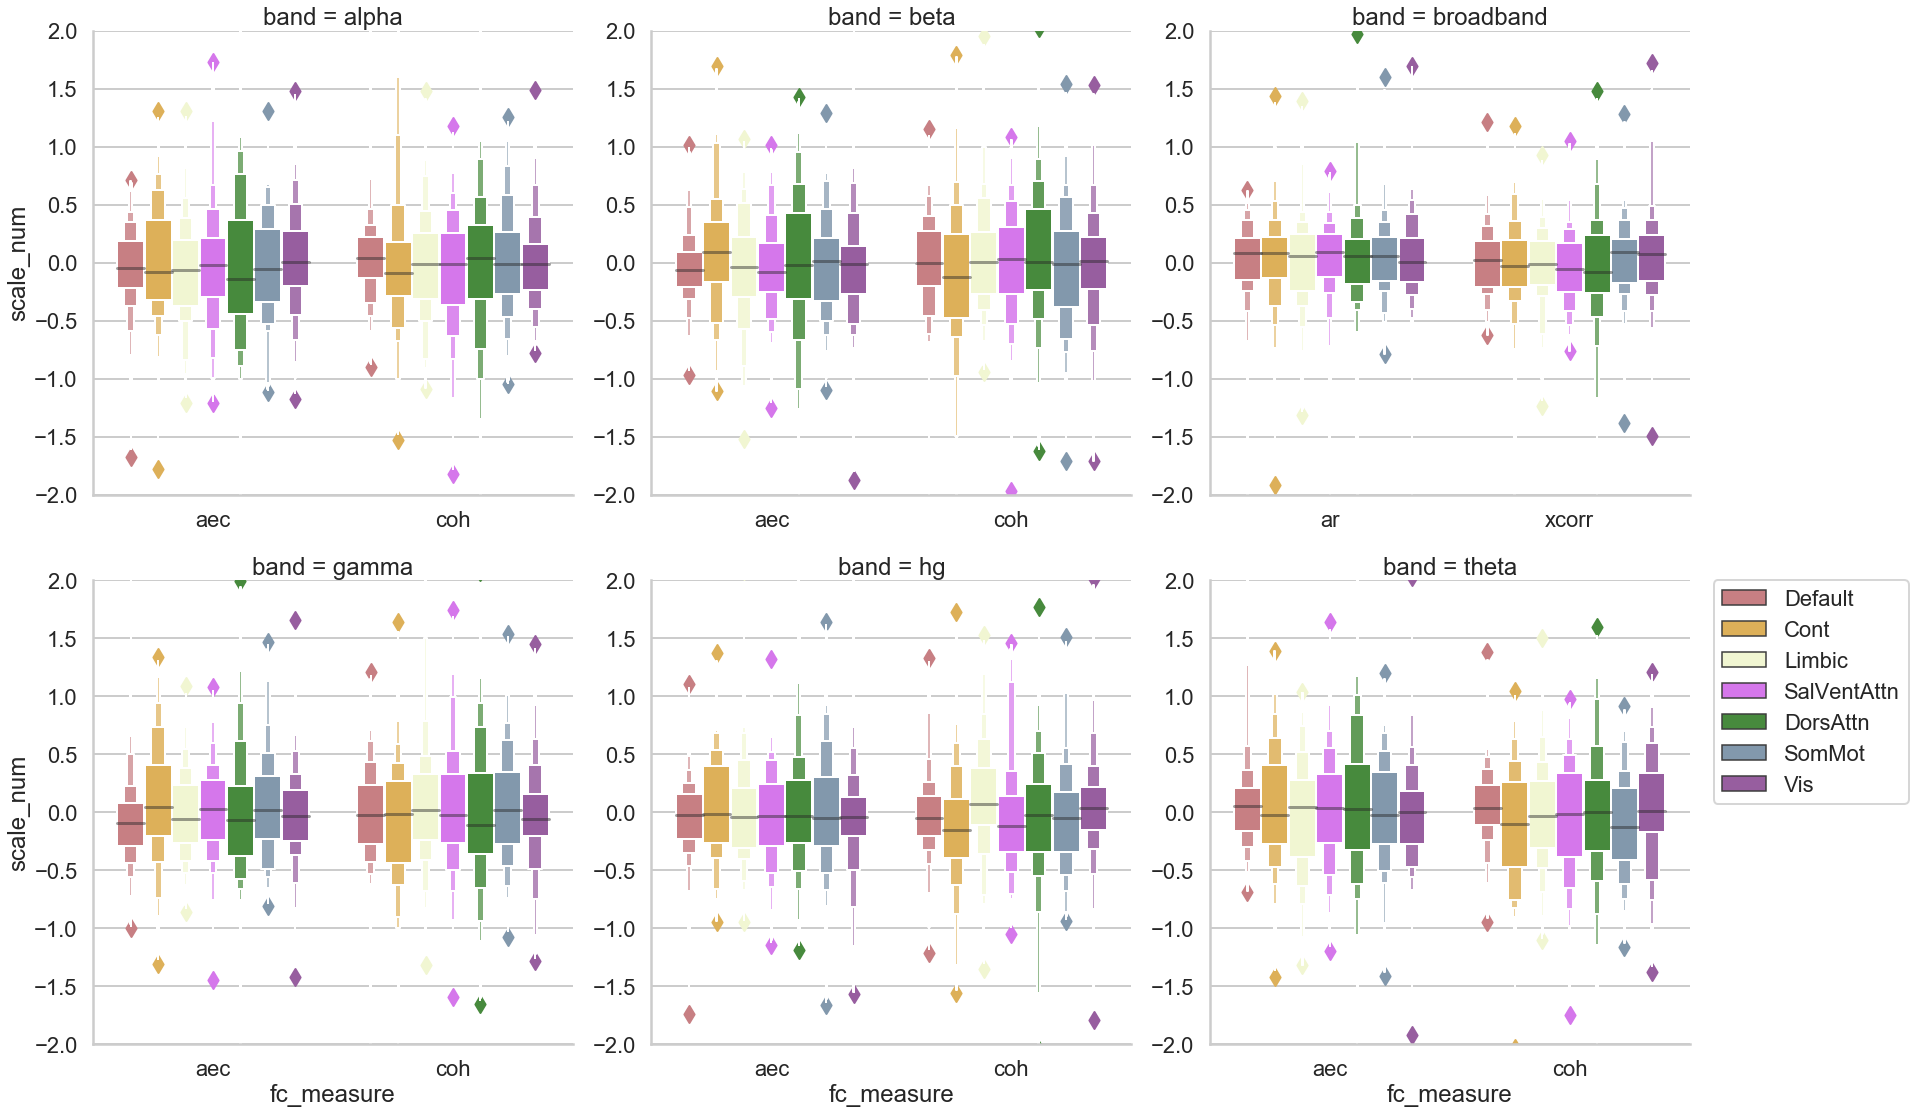

In [192]:
sys_avg = sys_avg[(sys_avg['fc_measure'] != 'aec_ortho') & (sys_avg['fc_measure'] != 'plv')]
g = sns.FacetGrid(data=sys_avg, col='band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'fc_measure', 'scale_num', 'sys', palette = sys_pal,
     hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.set_ylim(-2,2)
    
#g.savefig("../img/net_num.eps")

### Categorize SOZ

In [193]:
# check labels of elecs in soz for which sys they are in
flag = 'soz' # spike or soz

epilepsy_type = pd.DataFrame(data={'subj':node_data.subj.unique(), 
                                   'locus':np.empty(node_data.subj.unique().shape)})
for index,row in epilepsy_type.iterrows():
    if flag == 'spike':
        curr = node_data[(node_data['subj'] == row.subj)]
        curr = curr[curr['elec_spike'] > curr[curr['elec_spike'] != 0]['elec_spike'].median()]
    else:
        curr = node_data[(node_data['subj'] == row.subj) & (node_data['elec_in_soz'] == 1)]
    if (np.shape(curr)[0] == 0) | (any(curr.sys.isna())):
        epilepsy_type.loc[index, 'locus'] = np.nan
    else:
        epilepsy_type.loc[index,'locus'] = curr.sys.mode()[0]
    
epilepsy_type.head()           

subj     locus
0  R1170J  DorsAttn
1  R1291M       Vis
2  R1289C       Vis
3  R1284N       Vis
4  R1283T       Vis

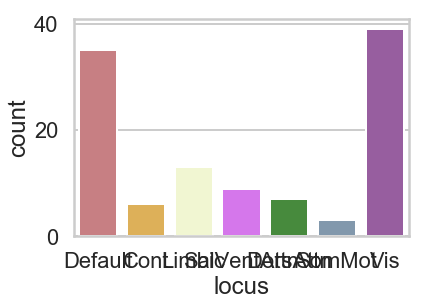

In [194]:
sns.countplot(data=epilepsy_type, x='locus', palette = sys_pal, 
              order = ['Default', 'Cont','Limbic', 'SalVentAttn','DorsAttn', 'SomMot','Vis'],
             hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])

In [195]:
# add locus back to big data frames
net_data = pd.merge(net_data, epilepsy_type, on='subj')
node_data = pd.merge(node_data, epilepsy_type, on='subj')
net_data.head()

band_measure  n_tp  str_beta_bin  str_beta_num  str_soz_beta_bin  \
0        alpha_aec   107      0.854233     -0.308418          1.059740   
1  alpha_aec_ortho   107      0.740682     -0.253151          1.870519   
2        alpha_coh   107      0.590071     -0.136139          1.332877   
3        alpha_plv   107      1.382341     -0.571861          0.567091   
4         beta_aec   107     -0.241167     -0.055265         -0.172447   

   str_soz_beta_num  str_not_soz_beta_num  str_spike_beta_num  \
0         -0.420497             -0.270865           -0.142973   
1         -0.708609             -0.065400           -0.561334   
2         -0.490406             -0.045080            0.038881   
3         -0.355160             -0.562533           -0.177097   
4         -0.067385             -0.053229            0.043149   

   str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
0              0.792757            0.498661                0.891197   
1              0.308119            1.454746                0.603182   
2              0.405967            0.215112                0.562521   
3              1.409217            0.125400                1.567178   
4             -0.215706           -0.657497               -0.123200   

     Measure  str_not_spike_beta_num Frequency Band    subj hand   age gender  \
0        aec               -0.329908          Alpha  R1170J    R  20.0      M   
1  aec_ortho               -0.168891          Alpha  R1170J    R  20.0      M   
2        coh               -0.156657          Alpha  R1170J    R  20.0      M   
3        plv               -0.599338          Alpha  R1170J    R  20.0      M   
4        aec               -0.079059           Beta  R1170J    R  20.0      M   

   race     locus  
0   2.0  DorsAttn  
1   2.0  DorsAttn  
2   2.0  DorsAttn  
3   2.0  DorsAttn  
4   2.0  DorsAttn

In [196]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3780 entries, 0 to 3779
Data columns (total 20 columns):
band_measure              3780 non-null object
n_tp                      3780 non-null int64
str_beta_bin              3717 non-null float64
str_beta_num              3717 non-null float64
str_soz_beta_bin          2730 non-null float64
str_soz_beta_num          2730 non-null float64
str_not_soz_beta_num      2720 non-null float64
str_spike_beta_num        2541 non-null float64
str_not_soz_beta_bin      2720 non-null float64
str_spike_beta_bin        2541 non-null float64
str_not_spike_beta_bin    2529 non-null float64
Measure                   3780 non-null object
str_not_spike_beta_num    2529 non-null float64
Frequency Band            3780 non-null object
subj                      3780 non-null object
hand                      3780 non-null object
age                       3780 non-null float64
gender                    3780 non-null object
race                      3780 non-nu

## Net plots with category by locus

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


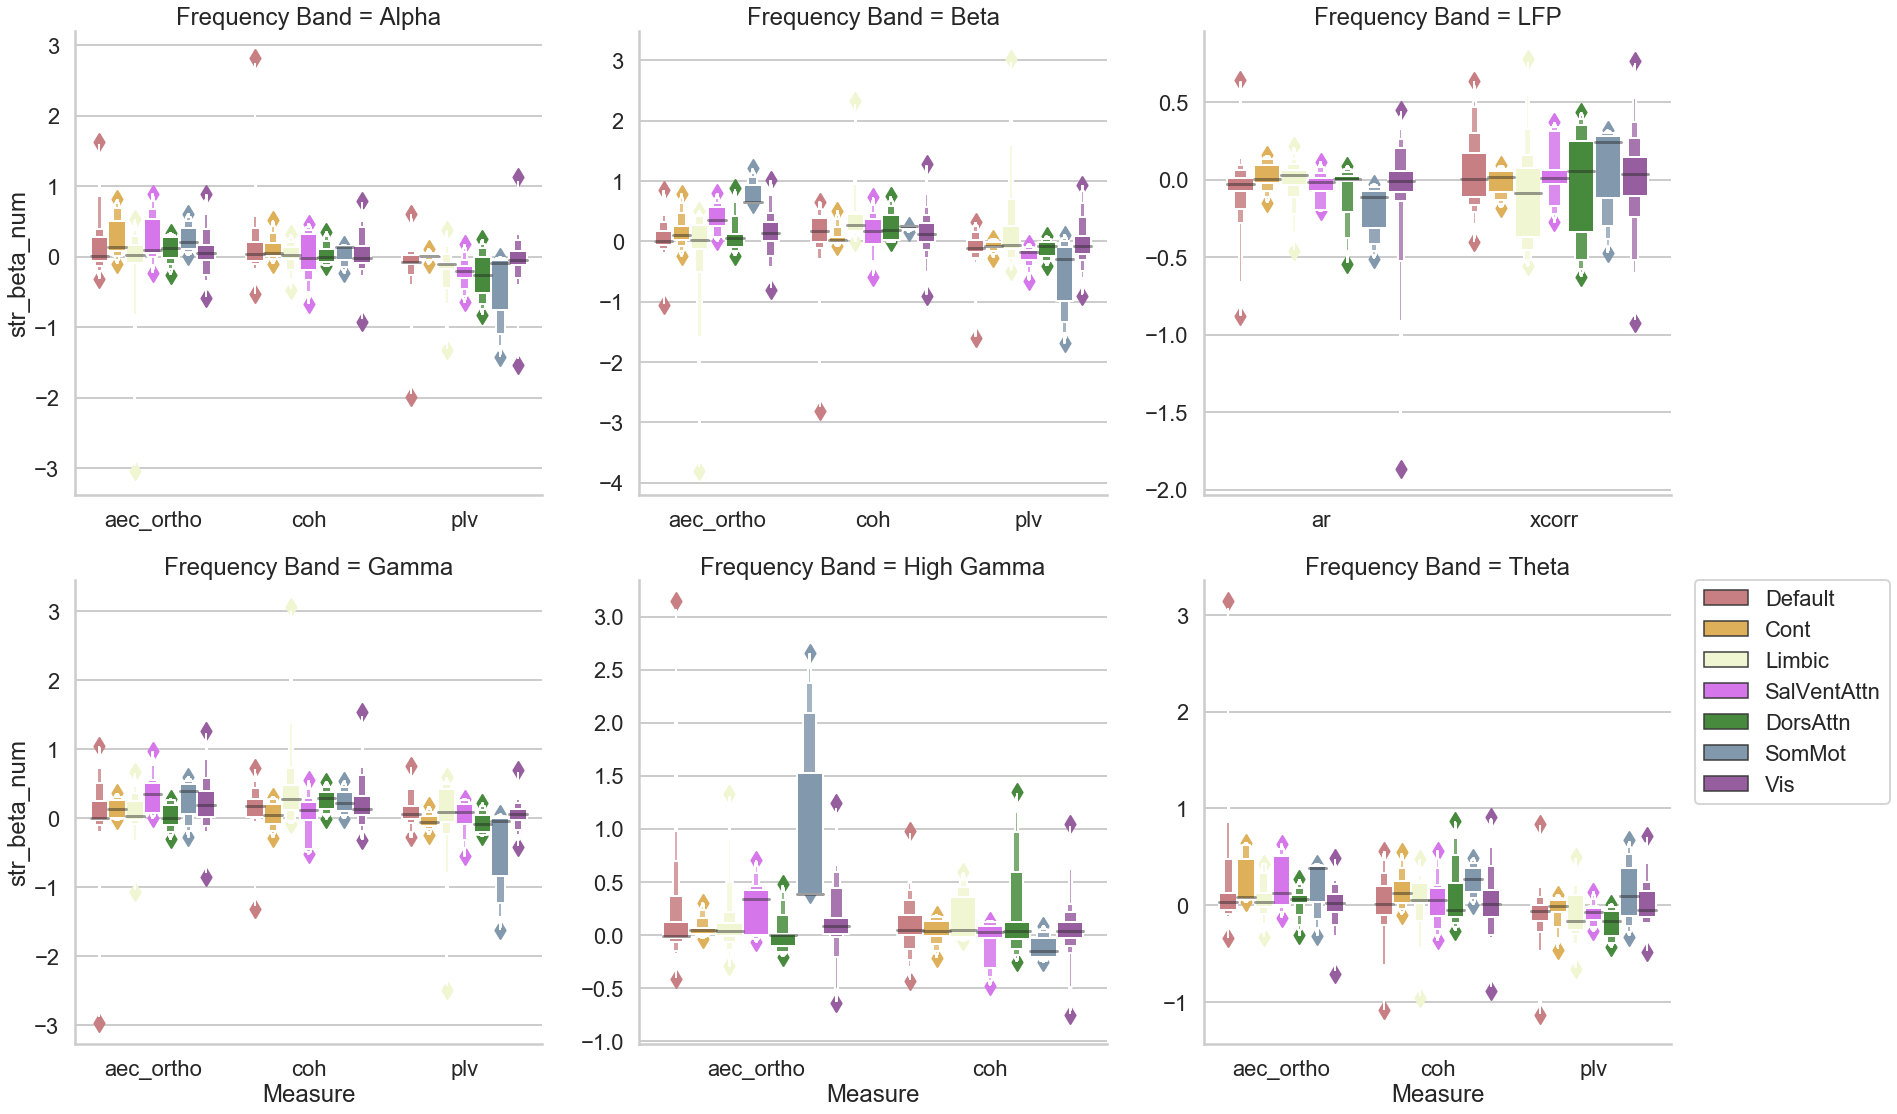

In [197]:
g = sns.FacetGrid(data=net_data[net_data.Measure != 'aec'], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_num', 'locus', palette = sys_pal, 
      hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-5,5)
    


In [199]:
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_{flag}{detector}.csv')

## Behavior

In [200]:
task_data = pd.read_csv(f'{RAM_dir}group_analysis/task_performance.csv', index_col=0)
task_data.reset_index(inplace=True)
task_data.head(10)

subj        YC  TH       PAL  catFR        FR
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573
1  R1002P       NaN NaN  0.492335    NaN  0.945857
2  R1003P       NaN NaN  0.083711    NaN  0.602817
3  R1004D       NaN NaN       NaN  0.625       NaN
4  R1006P  0.401778 NaN       NaN    NaN  0.779412
5  R1008J  0.530724 NaN       NaN    NaN       NaN
6  R1009W  0.183700 NaN       NaN    NaN       NaN
7  R1010J  0.358207 NaN       NaN    NaN  0.825373
8  R1013E  0.182021 NaN       NaN    NaN       NaN
9  R1014D  0.354468 NaN       NaN    NaN       NaN

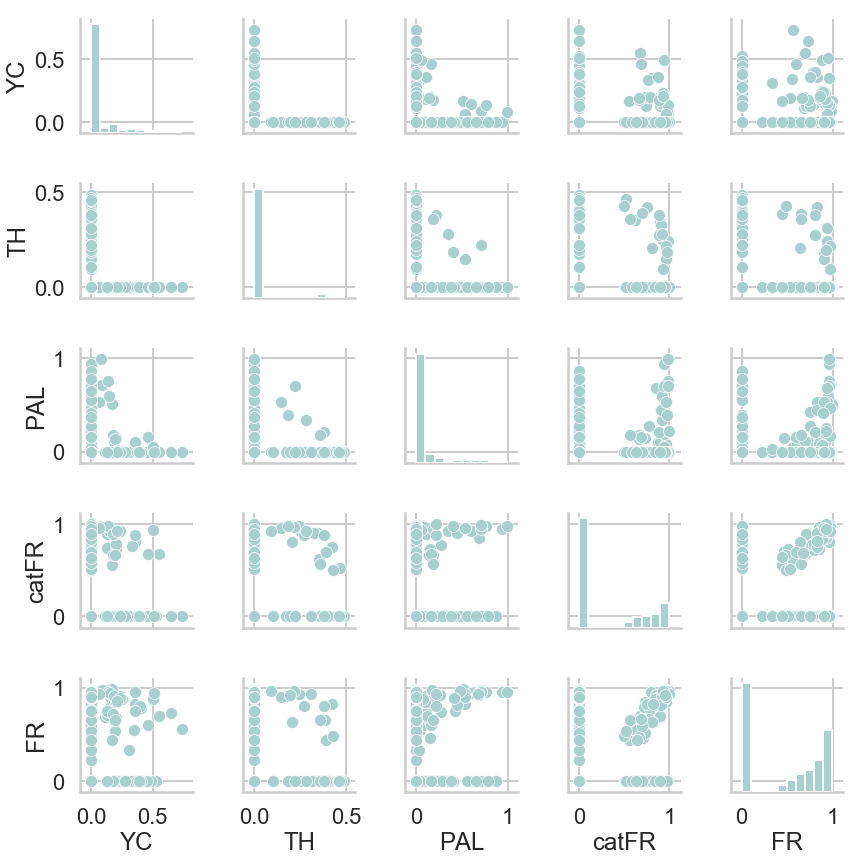

In [201]:
sns.pairplot(data=task_data.fillna(0), vars=['YC','TH','PAL','catFR','FR'])

In [202]:
# add averages over recal and nav tasks
task_data = task_data.assign(recall = task_data[['catFR','FR','PAL']].mean(axis=1, skipna=True))
task_data = task_data.assign(nav = task_data[['TH','YC']].mean(axis=1, skipna=True))
task_data = task_data.assign(avg = task_data[['nav','recall']].mean(axis=1, skipna=True))
task_data.head()

subj        YC  TH       PAL  catFR        FR    recall       nav  \
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573  0.293972  0.345526   
1  R1002P       NaN NaN  0.492335    NaN  0.945857  0.719096       NaN   
2  R1003P       NaN NaN  0.083711    NaN  0.602817  0.343264       NaN   
3  R1004D       NaN NaN       NaN  0.625       NaN  0.625000       NaN   
4  R1006P  0.401778 NaN       NaN    NaN  0.779412  0.779412  0.401778   

        avg  
0  0.319749  
1  0.719096  
2  0.343264  
3  0.625000  
4  0.590595

In [203]:
# merge with net_data
subj_idx = [x in net_data.subj.unique() for x in task_data.subj]
task_data = task_data[subj_idx]
net_task_data = pd.merge(net_data, task_data, on=['subj'])
net_task_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 28 columns):
band_measure              4410 non-null object
n_tp                      4410 non-null int64
str_beta_bin              4347 non-null float64
str_beta_num              4347 non-null float64
str_soz_beta_bin          3108 non-null float64
str_soz_beta_num          3108 non-null float64
str_not_soz_beta_num      3098 non-null float64
str_spike_beta_num        2793 non-null float64
str_not_soz_beta_bin      3098 non-null float64
str_spike_beta_bin        2793 non-null float64
str_not_spike_beta_bin    2781 non-null float64
Measure                   4410 non-null object
str_not_spike_beta_num    2781 non-null float64
Frequency Band            4410 non-null object
subj                      4410 non-null object
hand                      4410 non-null object
age                       4410 non-null float64
gender                    4410 non-null object
race                      4410 non-nu

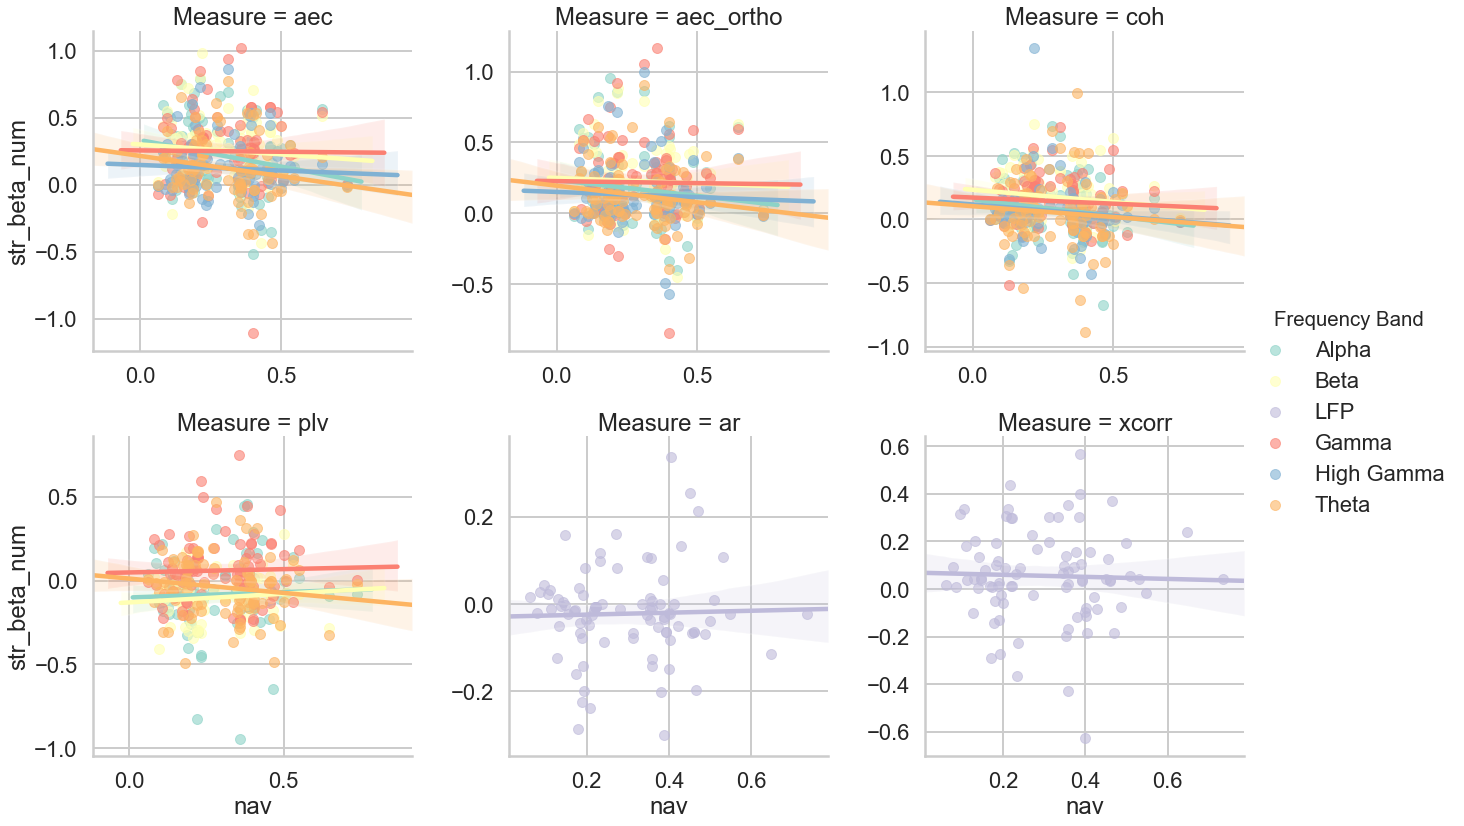

In [205]:
sns.lmplot(data=net_task_data, x='nav', y='str_beta_num', hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, palette='Set3', scatter_kws={'s':100, 'alpha':.6})

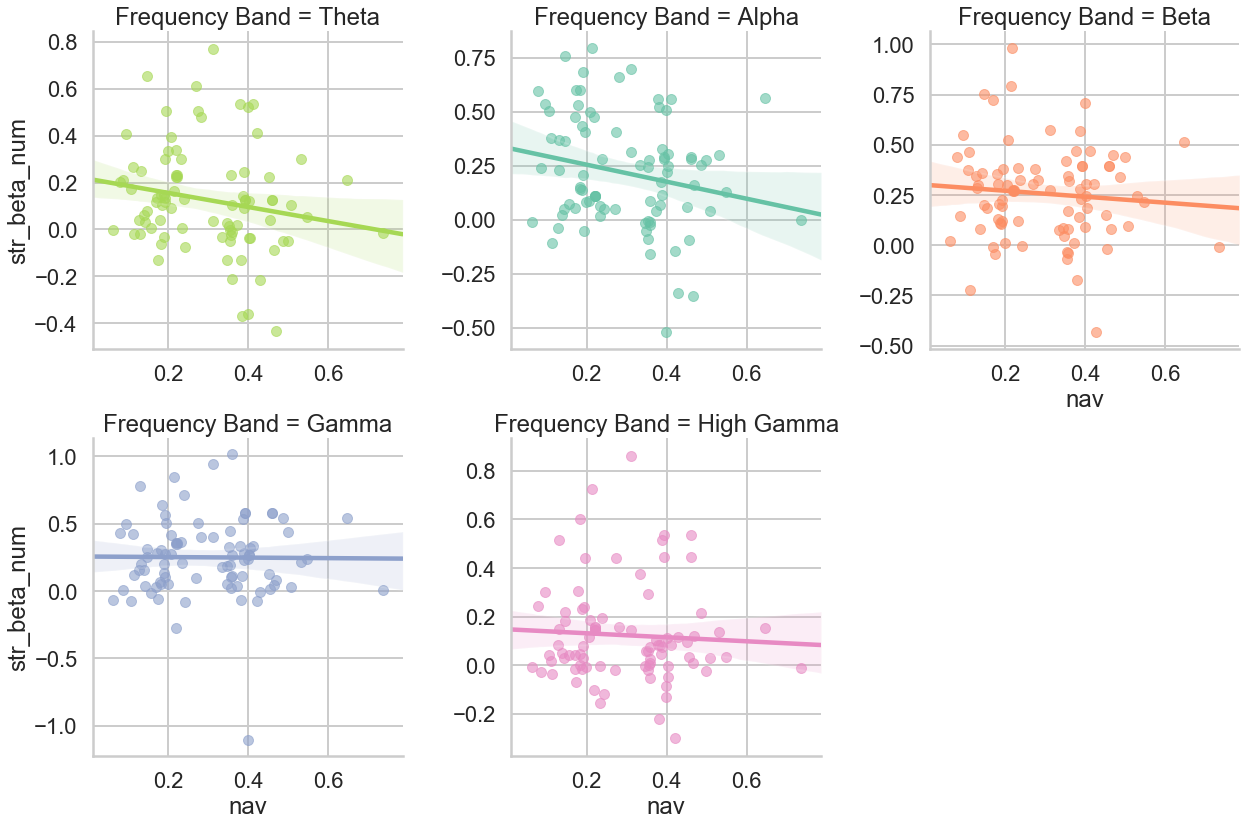

In [207]:
sns.lmplot(data=net_task_data[net_task_data['Measure'] == 'aec'], x='nav', y='str_beta_num', hue='Frequency Band', col="Frequency Band", 
           col_wrap=3, height=6, sharex=False, sharey=False, palette='Set2', scatter_kws={'s':100, 'alpha':.6}, col_order=['Theta','Alpha','Beta','Gamma','High Gamma'])
plt.savefig(f"../img/task_perf_band{detector}.eps")

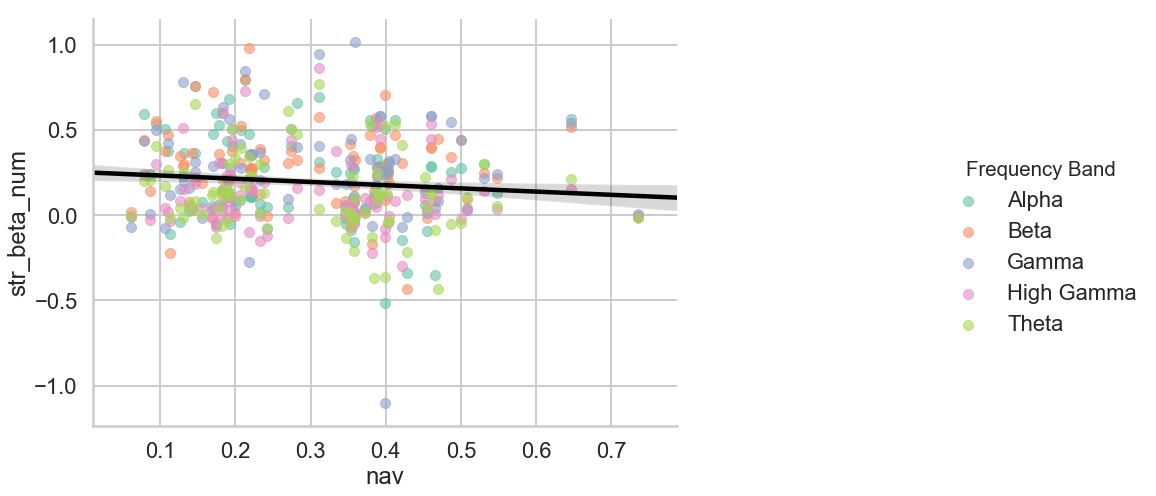

In [208]:
g = sns.lmplot(data=net_task_data[net_task_data['Measure'] == 'aec'], x='nav', y='str_beta_num', hue='Frequency Band', fit_reg=False,
           height=6, sharex=False, sharey=False, palette='Set2', scatter_kws={'s':100, 'alpha':.6})
sns.regplot(data=net_task_data[net_task_data['Measure'] == 'aec'], x='nav', y='str_beta_num', scatter=False, ax=g.axes[0,0], color='black')
g.fig.set_figwidth(20)
g.fig.set_figheight(8)
plt.savefig(f"../img/task_perf_band{detector}.eps")

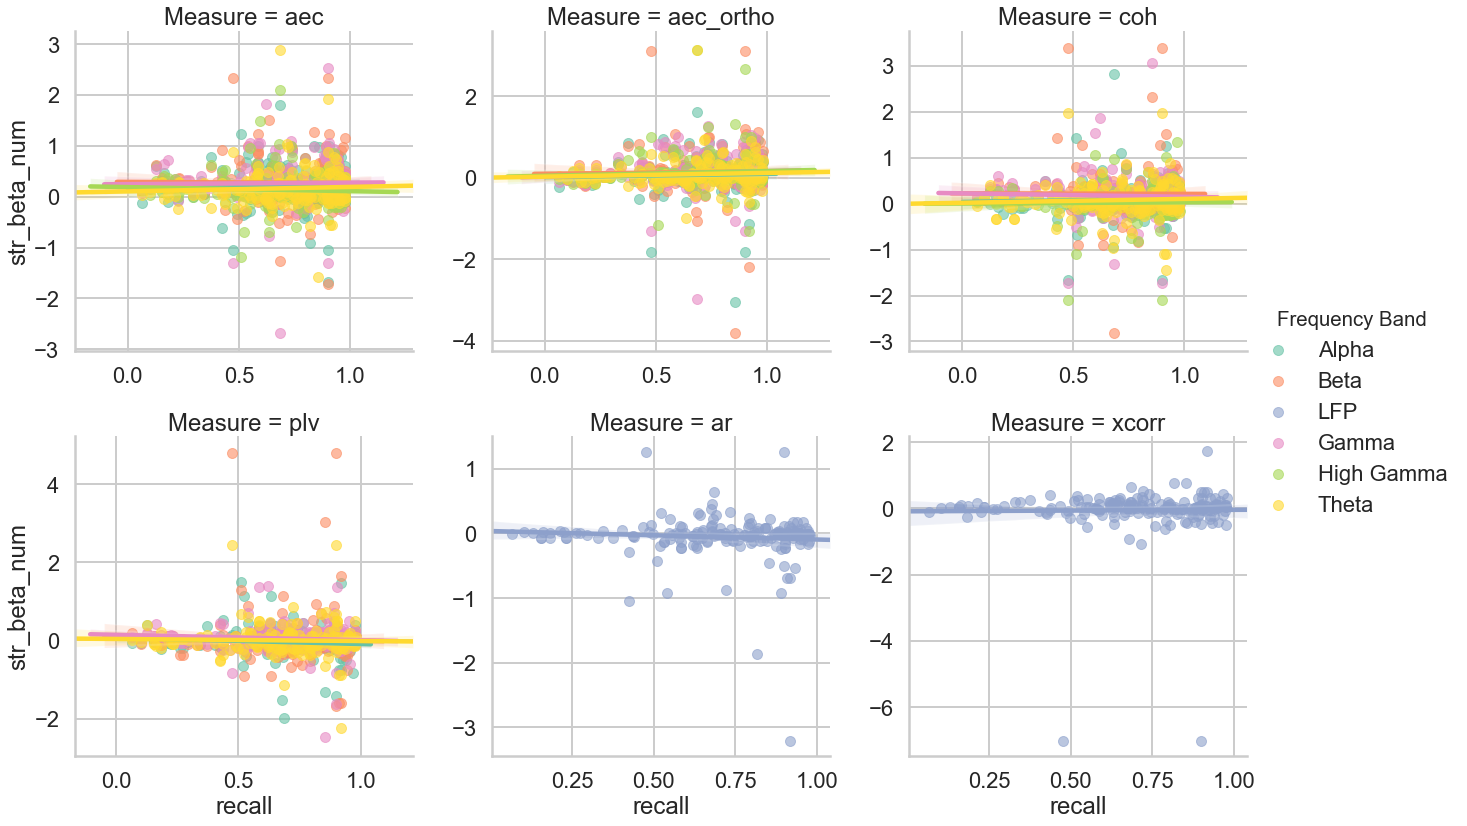

In [209]:
sns.lmplot(data=net_task_data, x='recall', y='str_beta_num', hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, palette='Set2', scatter_kws={'s':100, 'alpha':.6})

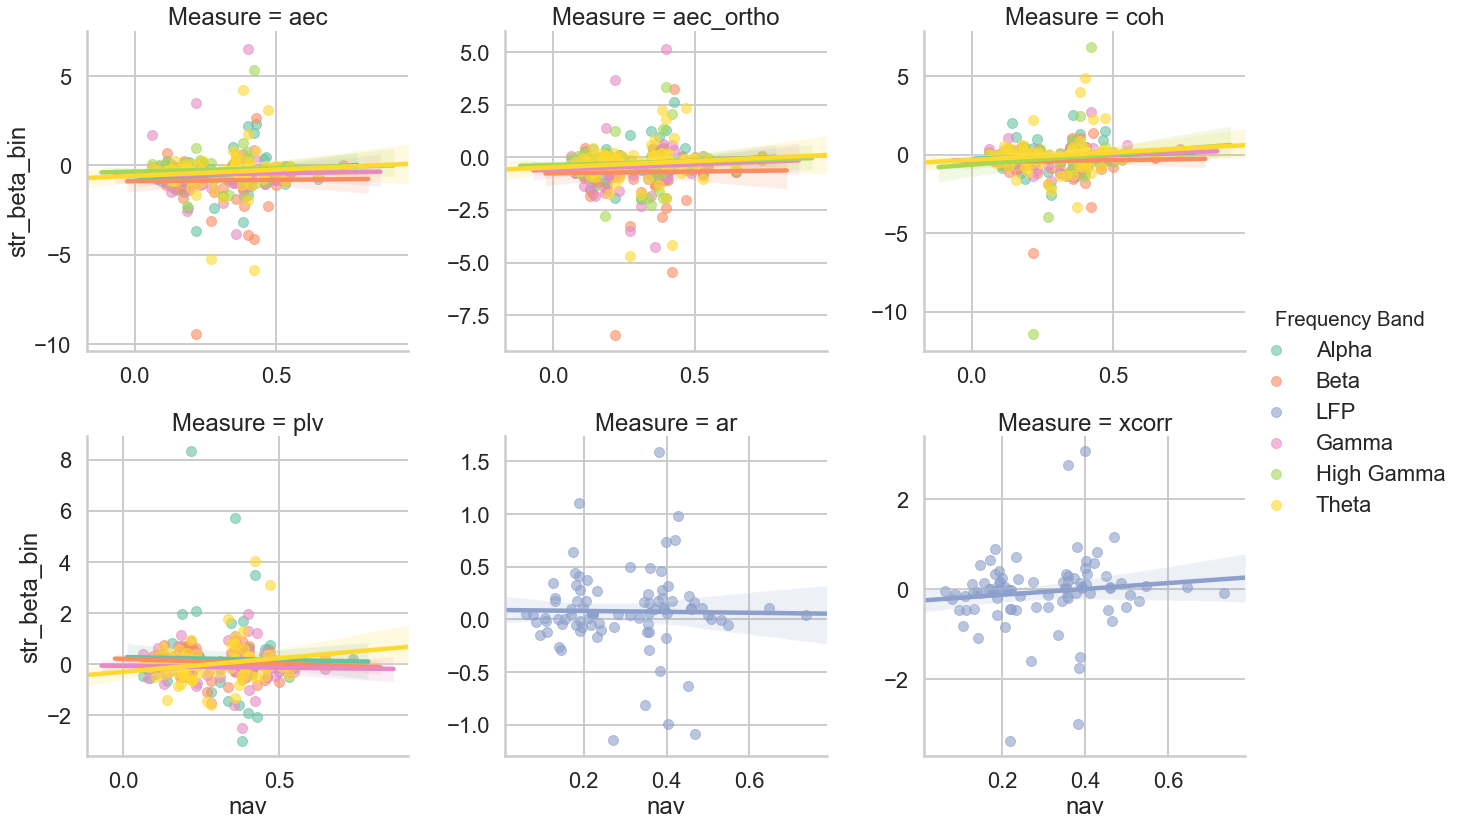

In [210]:
sns.lmplot(data=net_task_data, x='nav', y='str_beta_bin', hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, palette='Set2', scatter_kws={'s':100, 'alpha':.6})

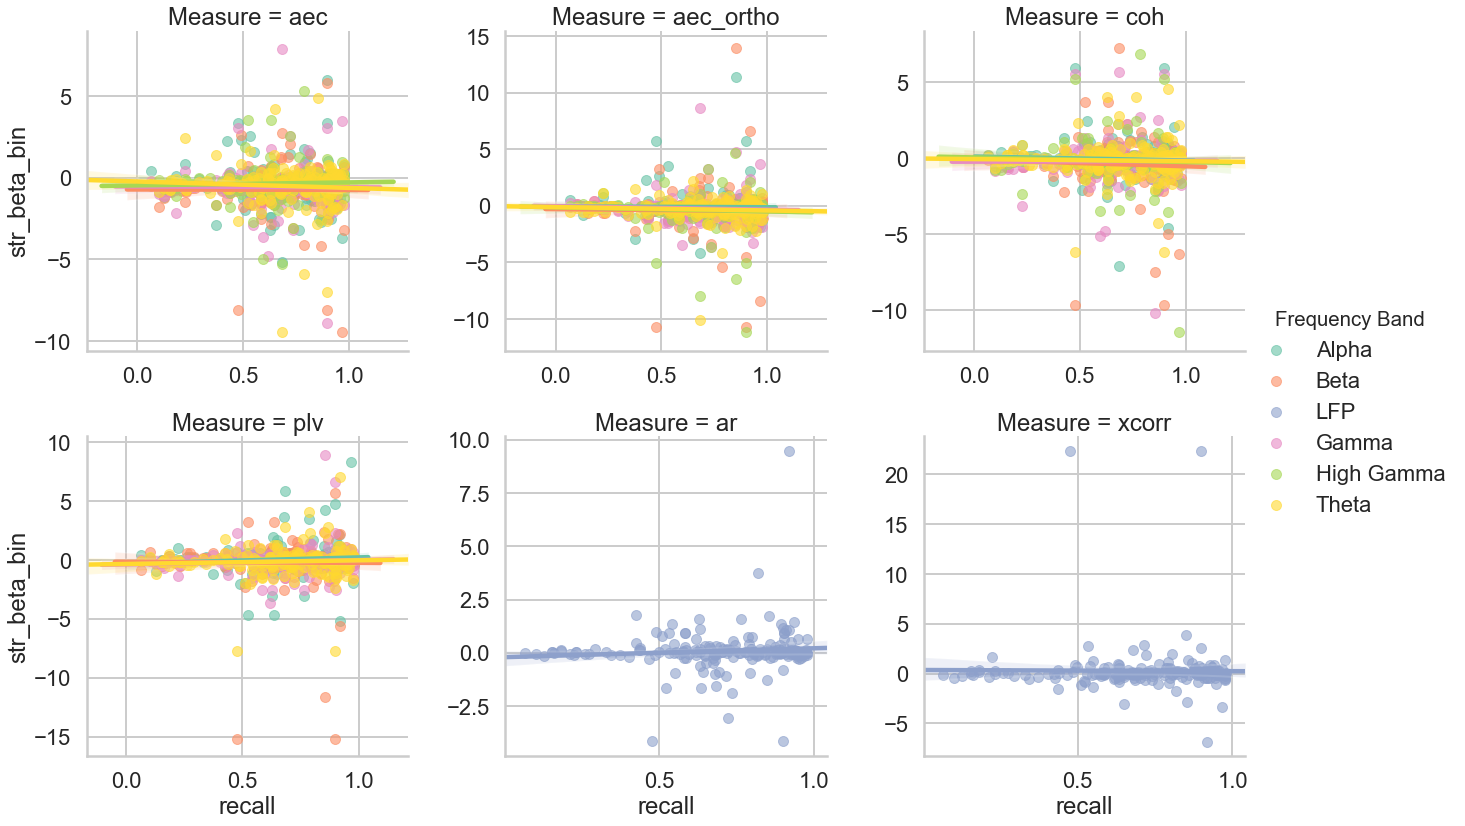

In [212]:
sns.lmplot(data=net_task_data, x='recall', y='str_beta_bin', hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, palette='Set2', scatter_kws={'s':100, 'alpha':.6})

In [213]:
# save
net_task_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_task_data_clean{detector}.csv')

Other parameters

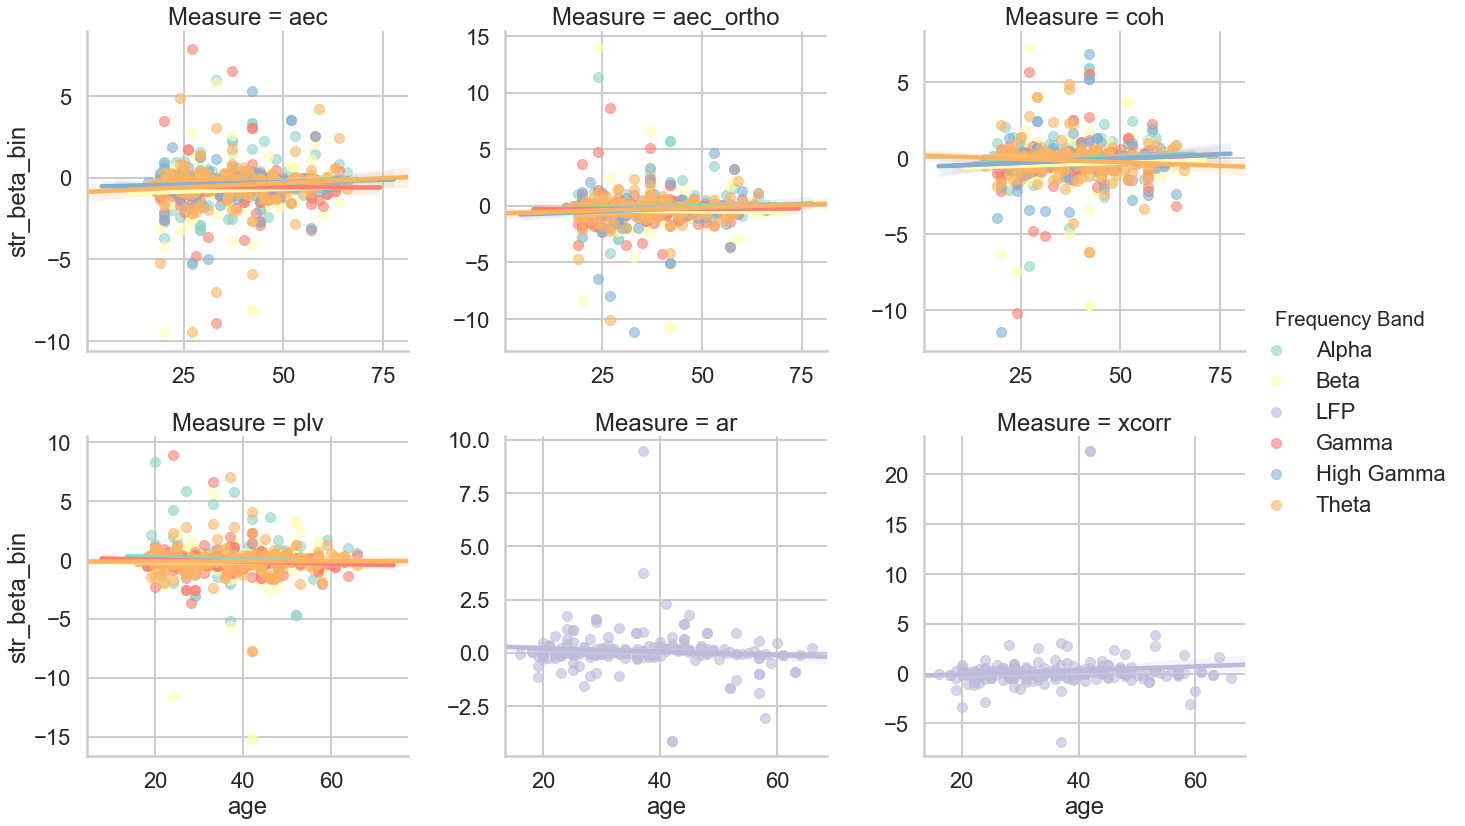

In [214]:
sns.lmplot(data=net_task_data, x='age', y='str_beta_bin', hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, palette='Set3', scatter_kws={'s':100, 'alpha':.6})

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


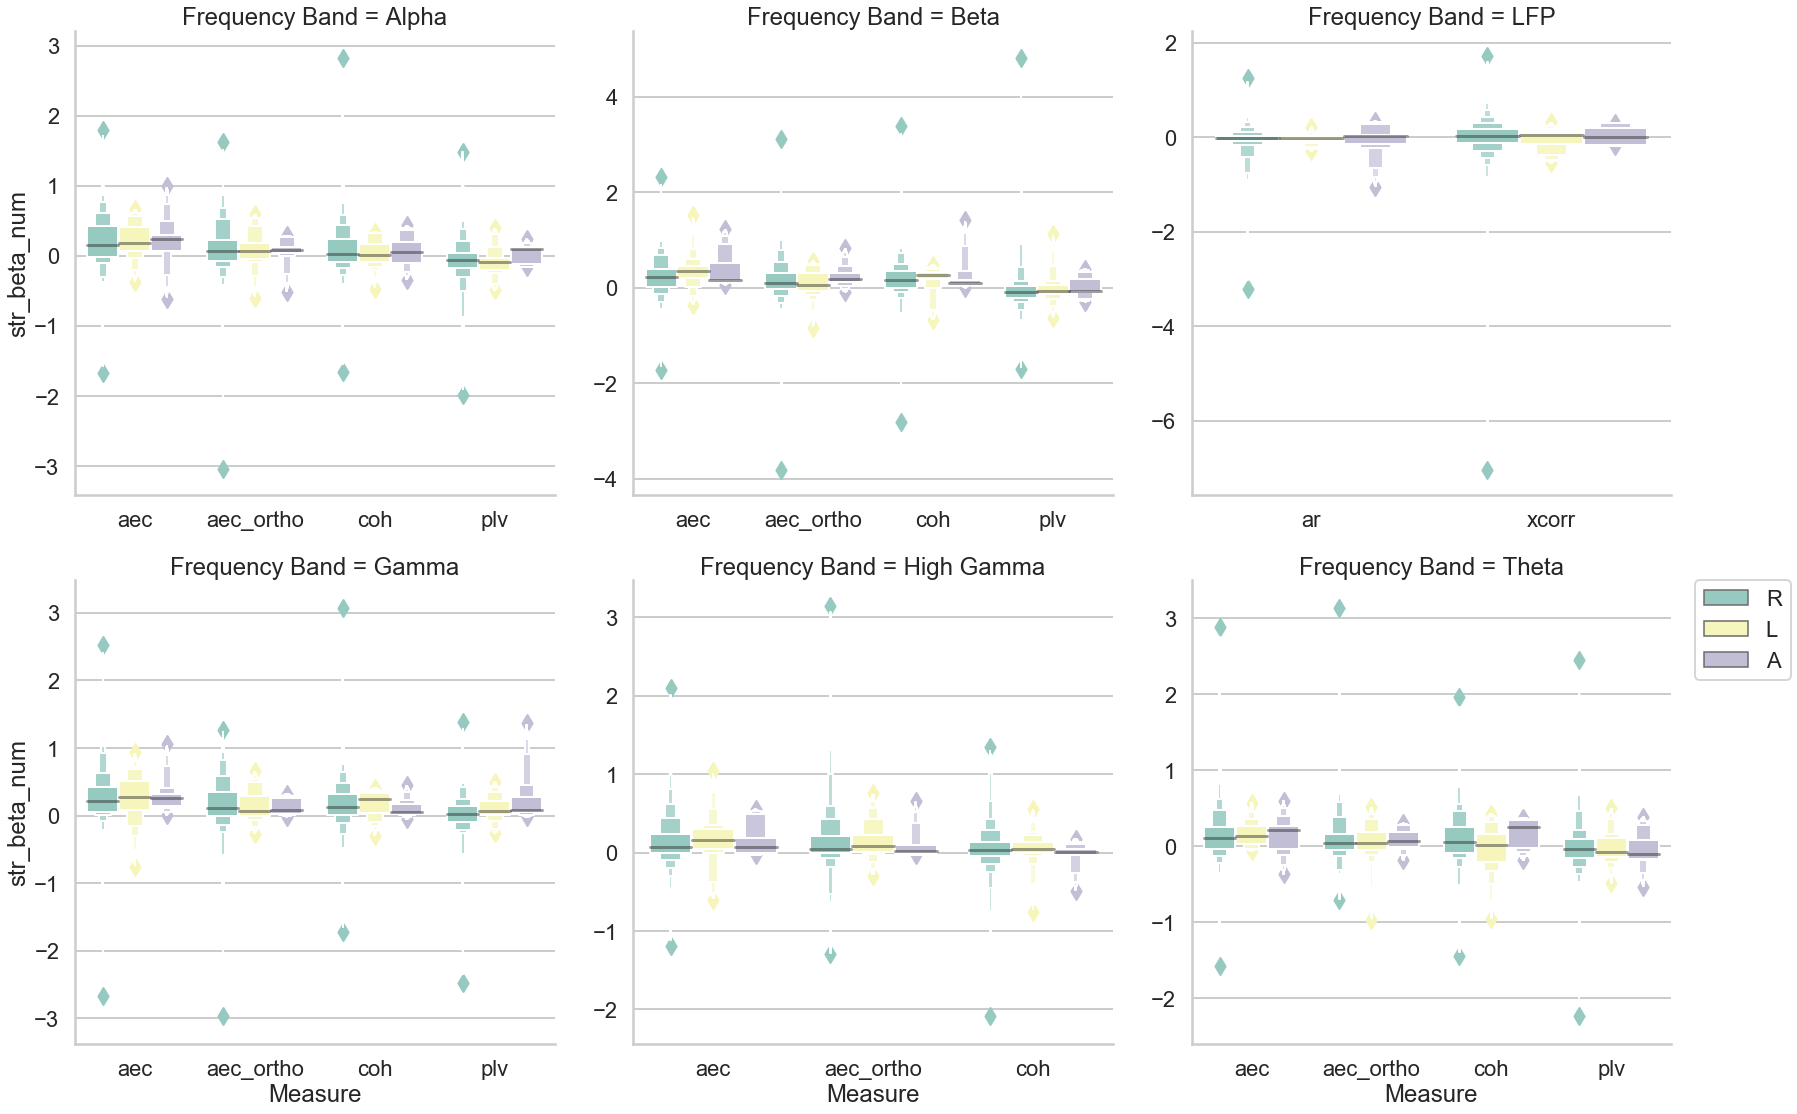

In [215]:
g = sns.FacetGrid(data=net_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_num', 'hand', palette = "Set3", hue_order=['R','L', 'A'])
#g.map(sns.stripplot, 'fc_measure', 'spike_beta_num', 'spike',jitter=True, dodge=True,
#              alpha=.2, zorder=1, size=6, hue_order=['str_spike_beta_num','str_not_spike_beta_num'])
# g.axes[0].set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)
# g.axes[1].set_xticklabels(g.axes[1].xaxis.get_majorticklabels(),rotation=30)
# g.axes[2].set_xticklabels(g.axes[2].xaxis.get_majorticklabels(),rotation=30)
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)